## Notebook for evaluation and analysis

### Setups

In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
from ast import literal_eval
import json
import re
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from scipy.stats import entropy, wasserstein_distance

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification 

from simulation_utils import eval_ans, call_api, extract_ans, extract_conf
from analysis_utils import interval_ece, brier_score, plot_reliability_diagram, plot_majority_confidences, plot_roc

%load_ext dotenv
%dotenv

In [7]:
from getpass import getpass
openai_api_key = getpass()

In [3]:
hf_cache_dir = "../data/hf_cache"
nli_model = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"

In [4]:
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model, cache_dir=hf_cache_dir)
nli_classifier = AutoModelForSequenceClassification.from_pretrained(nli_model, cache_dir=hf_cache_dir)

In [5]:
def read_data(dataset, fpath):
    results = [] 
    if dataset in ["gsm8k-test", "ambigqa", "gpqa_diamond", "sciq-valid", "triviaqa-dev", "dateUnd", "prfLaw", "Biz-Ethics"]:
        with open(f"../data/memory/output/{fpath}", 'r', encoding='utf-8') as file:
            json_data = re.sub(r"}\s*{", "},{", file.read())
            results.extend(json.loads("[" + json_data + "]"))
    else:
        with open(f"../data/memory/output/{fpath}", "r", encoding='utf-8') as fp:
            json_list = list(fp)
            
        for json_str in json_list:
            results.append(json.loads(json_str))

    converters = (
        {"reference_answers": literal_eval}
        if dataset in ["triviaqa-dev", "truthfulqa", "ambigqa"]
        else None
    )
    records = pd.read_csv(
        f"../data/benchmarks/preprocessed/{dataset}.csv", 
        converters=converters
    )
    if dataset == "ambigqa":
        records["reference_answers"] = [list(itertools.chain(*reference_answers)) for reference_answers in records["reference_answers"].to_list()]
    return results, records

In [6]:
zs_msg = "State your answer (as short as possible), and give a float (between 0.0 to 1.0) indicating your overall confidence on how likely that your answer is correct. Follow this format:\nAnswer:<answer>\nConfidence:<confidence>"

def get_zs(zs_msg, question):
    raw_res_zs = call_api(f"Question: {question}\n{zs_msg}")
    ans_zs = extract_ans(raw_res_zs)
    conf_zs = extract_conf(raw_res_zs)
    return ans_zs, conf_zs

In [7]:
def cluster_and_get_majority(votes, query, dataset="gsm8k-test"):
    # Following the Universal-SC paper, for GSM8K, use exact-match after extracting the numerical answers
    classes = {}    
    for i, (ans, conf) in enumerate(votes):
        if dataset == "gsm8k-test":
            ans_numerical = re.findall(r'-?\d+\.?\d*', ans.replace(",", ""))
            if ans_numerical:
                ans = ans_numerical[0].replace(".0", "")                
            else:
                print(f"wrong ans format: {ans}, {ans_numerical}")
                
        if i == 0:
            classes.update({ans: [[conf], 1]})
        else:
            merged_answer_class = None
            for unique_class in classes.keys():
                if eval_ans(
                    query,
                    ans,
                    unique_class,
                    method="em" if dataset=="gsm8k-test" else "gpt_cls",
                    nli_classifier=nli_classifier,
                    nli_tokenizer=nli_tokenizer,
                ):
                    # not a new class, merge with the equivalent answer class
                    merged_answer_class = unique_class
                    confs, count = classes[merged_answer_class]
                    confs.append(conf)
                    count += 1
                    classes[merged_answer_class] = [confs, count]
                    break
            if not merged_answer_class:
                # a new class, add the answer to the answer set
                classes.update({ans: [[conf], 1]})
    classes_sorted = sorted(classes.items(), key=lambda item: item[1][-1], reverse=True)
    return classes_sorted[0]           

In [8]:
def get_acc_and_conf(results, records, dataset, judge="gpt_cls", zs_baseline=False, n_sample=3):
    acc_all, conf_all = [], []
    acc_all_zs, conf_all_zs = [], []
    for result in tqdm(results):
        curr = result["qid"]     
        row = records.loc[records["qid"] == curr]
        question = row["question"].to_list()[0]
        references = row["reference_answers"].to_list()[0]
        if zs_baseline:
            votes_zs = []
            for _ in range(n_sample):
                ans_zs_sample, conf_zs_sample = get_zs(zs_msg, question)
                votes_zs.append((ans_zs_sample, conf_zs_sample))
            majority_ans_zs, (majority_conf_zs, _) = cluster_and_get_majority(votes_zs, question, dataset)
            majority_conf_zs = np.mean(majority_conf_zs)               
            acc_zs = eval_ans(
                question, 
                majority_ans_zs, 
                references, 
                method = "em" if dataset == "gsm8k-test" else judge, 
                nli_classifier=nli_classifier, 
                nli_tokenizer=nli_tokenizer,
                openai_api_key=openai_api_key
            )
            acc_all_zs.append(int(acc_zs))
            conf_all_zs.append(majority_conf_zs)

        acc = eval_ans(
            question, 
            result["final_majority_ans"], 
            references, 
            method=judge, 
            nli_classifier=nli_classifier, 
            nli_tokenizer=nli_tokenizer,
            openai_api_key=openai_api_key
        )
        acc_all.append(int(acc))
        conf_all.append(result["final_verbal_confidence"])
    print(f"test run mean accuracy {np.mean(acc_all):.3f}, mean confidence {np.mean(conf_all):.3f}")
    if zs_baseline:
        consistency = f"maj1@{n_sample}" if n_sample > 1 else "greedy"
        print(f"{consistency}(0-shot) mean accuracy {np.mean(acc_all_zs):.3f}, mean confidence {np.mean(conf_all_zs):.3f}")
    return acc_all, conf_all, acc_all_zs, conf_all_zs

In [9]:
def deliberation_ablation(dataset="triviaqa-dev", fpath="old/triviaqa-dev-200.jsonl"):
    results, records = read_data(dataset=dataset, fpath=fpath)
    n = len(results)
    print(f"in total {n} examples")
    pre_len, post_len = [], []
    pre_acc_all, pre_conf_all = [], []
    n_early_consensus, n_early_consensus_correct, early_consensus_conf_boost = 0, 0, 0
    n_majority_changed, n_majority_changed_effective = 0, 0
    pre_majority_freq_all, post_majority_freq_all = [], []
    post_acc_all, post_conf_all = [], []
    pre_non_majority_confs, post_non_majority_confs = [], []
    emd, kl = [], []
    for result in tqdm(results):
        row_gt = records.loc[records["qid"] == result["qid"]]
        question = row_gt["question"].to_list()[0]
        gold_refs = row_gt["reference_answers"].to_list()[0]
        pre_dist = result["original_stances"]  # sorted
        post_dist = result["final_stances"]

        # simple statistics
        pre_len.append(len(pre_dist))

        pre_ans = [v["answer_class"] for v in pre_dist]
        pre_counts = [v["count"] for v in pre_dist]
        pre_confs = [v["avg_verbal_confidence"] for v in pre_dist]
        pre_majority_ans, pre_majority_count, pre_majority_conf = pre_ans[-1], pre_counts[-1], pre_confs[-1]
        pre_acc = eval_ans(question, pre_majority_ans, gold_refs, method="gpt_cls", openai_api_key=openai_api_key) 
        pre_acc_all.append(int(pre_acc))  
        pre_conf_all.append(pre_majority_conf)
        if len(pre_confs) > 1:
            pre_non_majority_confs.append(np.mean(pre_confs[:-1]))
        else:
            pre_non_majority_confs.append(pre_majority_conf)
        pre_majority_freq_all.append(pre_majority_count/np.sum(pre_counts))

        post_len.append(len(post_dist))
        post_ans = [v["answer_class"] for v in post_dist]
        post_counts = [v["count"] for v in post_dist]
        post_confs = [v["avg_verbal_confidence"] for v in post_dist]
        post_majority_ans, post_majority_count, post_majority_conf = post_ans[-1], post_counts[-1], post_confs[-1]
        post_acc = eval_ans(question, post_majority_ans, gold_refs, method="gpt_cls", openai_api_key=openai_api_key) 
        post_acc_all.append(int(post_acc)) 
        post_conf_all.append(post_majority_conf)        
        if len(post_confs) > 1:
            post_non_majority_confs.append(np.mean(post_confs[:-1]))
        else:
            post_non_majority_confs.append(post_majority_conf)
        post_majority_freq_all.append(post_majority_count/np.sum(post_counts))

        if len(pre_dist) == 1:
            n_early_consensus += 1
            if pre_acc:
                n_early_consensus_correct += 1
                early_consensus_conf_boost += post_majority_conf - pre_majority_conf
        else:
            # compare answer distribution
            pre_post_mapping = {ans: 0 for ans in pre_ans}
            for i, post in enumerate(post_ans):
                recurring = False
                for pre in pre_ans:
                    if eval_ans(question, post, pre):
                        pre_post_mapping[pre] = post_counts[i]
                        recurring = True
                        break
                if not recurring:
                    pre_counts.append(post_counts[i])
                    pre_post_mapping.update({post: post_counts[i]})
            pre_post_mapped_counts = list(pre_post_mapping.values())
            emd.append(wasserstein_distance(pre_counts, pre_post_mapped_counts))
            pk = np.array(pre_post_mapped_counts) / np.linalg.norm(pre_post_mapped_counts)
            qk = np.array(pre_counts) / np.linalg.norm(pre_counts)
            kl.append(entropy(pk, qk))           

        if pre_acc != post_acc:
            n_majority_changed += 1
            if not pre_acc:
                n_majority_changed_effective += 1

    print(f"number of unique stances pre stage 2: {np.mean(pre_len):.3f}, post stage 2: {np.mean(post_len):.3f}")
    print(f"majority vote mean confidence pre stage 2: {np.mean(pre_conf_all):.3f}, post stage 2: {np.mean(post_conf_all):.3f}")
    print(f"non-majority mean confidence pre stage 2: {np.mean(pre_non_majority_confs):.3f}, post stage 2: {np.mean(post_non_majority_confs):.3f}")
    print(f"early consensus rate: {n_early_consensus/n:.3f}; early consensus being correct {n_early_consensus_correct/n_early_consensus:.2%} of the time, with avg confidence boost: {early_consensus_conf_boost/n_early_consensus_correct:.2%}")
    print(f"majority change rate: {n_majority_changed/n:.3f}; effective rate (changing from incorrect to correct): {n_majority_changed_effective/n_majority_changed:.2%} of the time.")
    print(f"compare between pre and post stance distributions - Wasserstein: {np.mean(emd):.3f} KL: {np.mean(kl):.3f}")

    display_labels=["incorrect", "correct"]
    plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1)
    sns.heatmap(confusion_matrix(pre_acc_all, post_acc_all, normalize="all"), annot=True, xticklabels=display_labels, yticklabels=display_labels, linewidths=1)
    plt.xlabel('Post stage 2')
    plt.ylabel('Pre stage 2')
    plt.show()

    plot_majority_confidences(pre_conf_all, pre_majority_freq_all, post_conf_all, post_majority_freq_all)
    plot_roc(pre_acc_all, pre_conf_all, "Verbal; pre stage 2")
    plot_roc(post_acc_all, post_conf_all, "Verbal; post stage 2")

    ece, prop_all_bins, accuracy_all_bins, bin_boundaries = interval_ece(pre_acc_all, pre_conf_all)
    bs = brier_score(pre_acc_all, pre_conf_all)
    plot_reliability_diagram(bin_boundaries, prop_all_bins, accuracy_all_bins, f"Pre - ECE: {ece:.3f}, Brier: {bs:.3f}")

In [10]:
def get_ece(dataset, fpath, zs_baseline=True, zs_consistency_n=1):
    res, records = read_data(dataset, fpath)
    acc_all, conf_all, acc_all_zs, conf_all_zs = get_acc_and_conf(res, records, dataset=dataset, zs_baseline=True, n_sample=zs_consistency_n)

    ece, prop_all_bins, accuracy_all_bins, bin_boundaries = interval_ece(acc_all, conf_all)
    bs = brier_score(acc_all, conf_all)
    plot_reliability_diagram(bin_boundaries, prop_all_bins, accuracy_all_bins, f"Post - ECE: {ece:.3f}, Brier: {bs:.3f}")

    if zs_baseline:
        ece, prop_all_bins, accuracy_all_bins, bin_boundaries = interval_ece(acc_all_zs, conf_all_zs)
        bs = brier_score(acc_all_zs, conf_all_zs)
        consistency = f"maj1@{zs_consistency_n}" if zs_consistency_n > 1 else "greedy"
        plot_reliability_diagram(bin_boundaries, prop_all_bins, accuracy_all_bins, f"{consistency}(0-shot) - ECE: {ece:.3f}, Brier: {bs:.3f}")

### Main Experiments

##### Biz-Ethics

100%|██████████| 100/100 [05:25<00:00,  3.25s/it]

test run mean accuracy 0.700, mean confidence 0.824
maj1@6(0-shot) mean accuracy 0.740, mean confidence 0.870


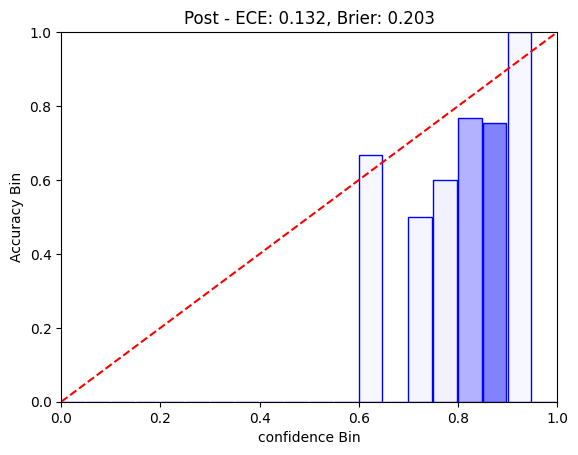

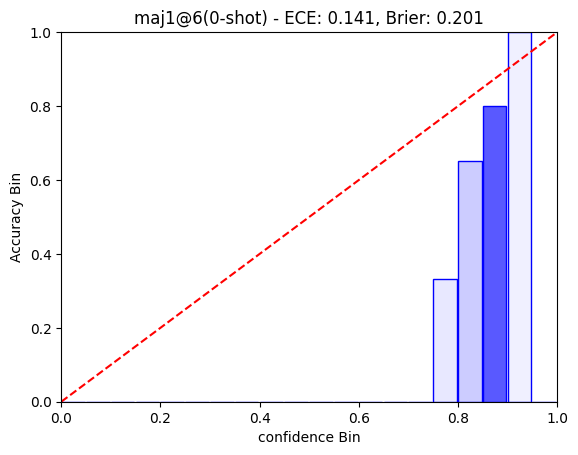

In [23]:
get_ece(dataset="Biz-Ethics", fpath="Biz-Ethics.jsonl", zs_baseline=True, zs_consistency_n=6)

in total 100 examples


100%|██████████| 100/100 [05:07<00:00,  3.08s/it]

number of unique stances pre stage 2: 2.170, post stage 2: 1.920
majority vote mean confidence pre stage 2: 0.715, post stage 2: 0.830
non-majority mean confidence pre stage 2: 0.727, post stage 2: 0.815
early consensus rate: 0.380; early consensus being correct 94.74% of the time, with avg confidence boost: 11.98%
majority change rate: 0.180; effective rate (changing from incorrect to correct): 38.89% of the time.
compare between pre and post stance distributions - Wasserstein: 0.804 KL: 0.599


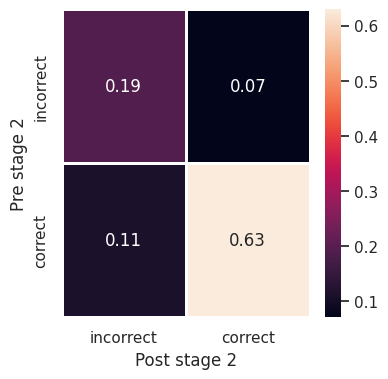

<Figure size 640x480 with 0 Axes>

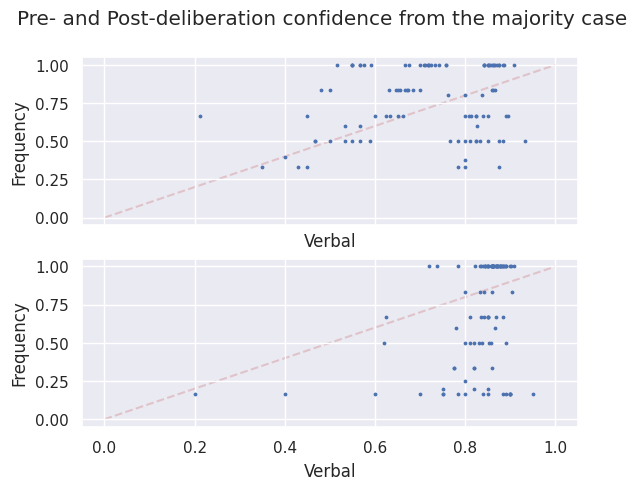

<Figure size 640x480 with 0 Axes>

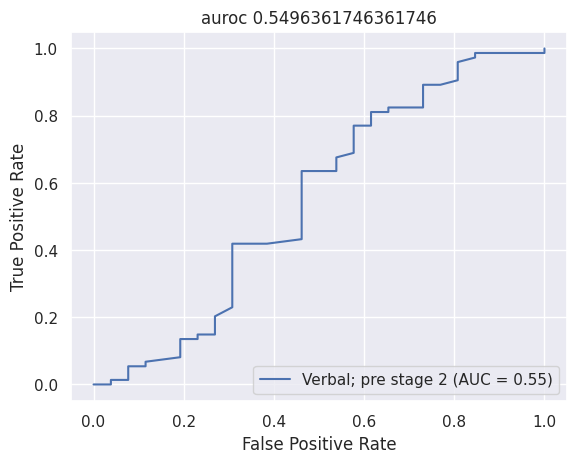

<Figure size 640x480 with 0 Axes>

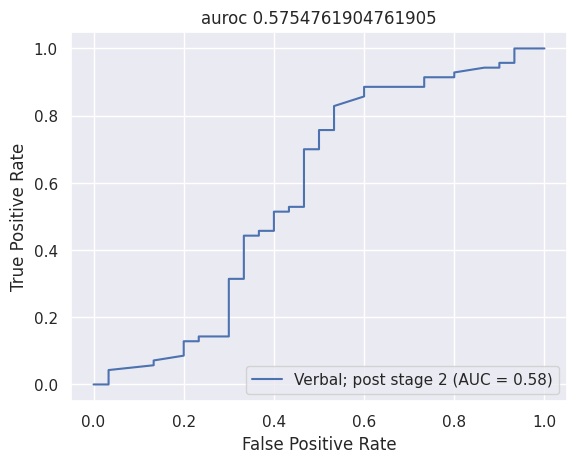

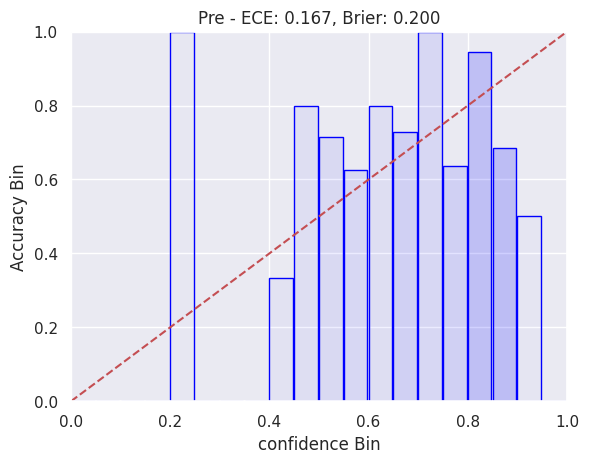

In [18]:
deliberation_ablation(dataset="Biz-Ethics", fpath="Biz-Ethics.jsonl")

##### dateUnd

100%|██████████| 249/249 [16:22<00:00,  3.95s/it]

test run mean accuracy 0.843, mean confidence 0.842
maj1@6(0-shot) mean accuracy 0.807, mean confidence 0.899


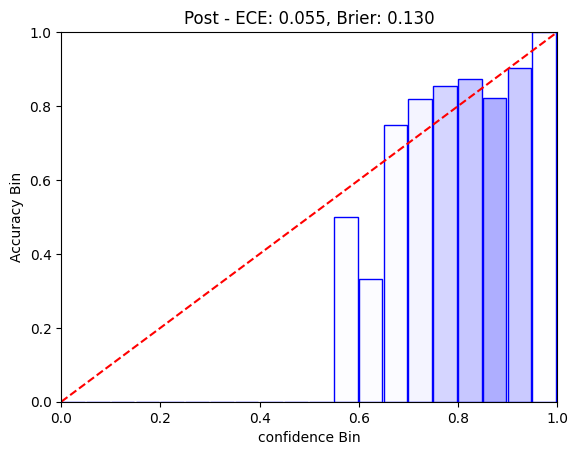

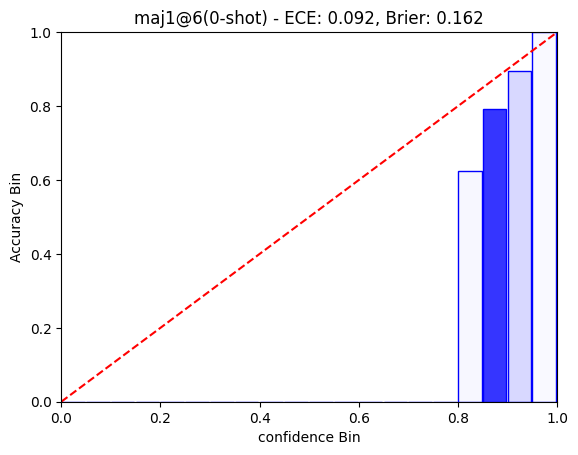

In [11]:
get_ece(dataset="dateUnd", fpath="dateUnd.jsonl", zs_baseline=True, zs_consistency_n=6)

in total 249 examples


100%|██████████| 249/249 [04:02<00:00,  1.03it/s]

number of unique stances pre stage 2: 1.900, post stage 2: 1.325
majority vote mean confidence pre stage 2: 0.828, post stage 2: 0.849
non-majority mean confidence pre stage 2: 0.821, post stage 2: 0.840
early consensus rate: 0.345; early consensus being correct 89.53% of the time, with avg confidence boost: 5.57%
majority change rate: 0.197; effective rate (changing from incorrect to correct): 57.14% of the time.
compare between pre and post stance distributions - Wasserstein: 1.390 KL: 0.709


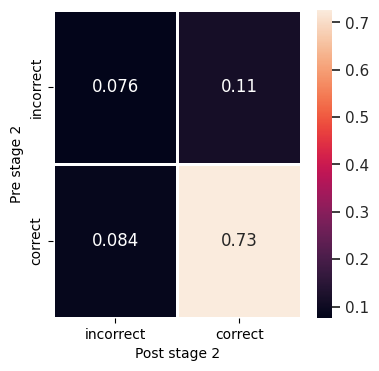

<Figure size 640x480 with 0 Axes>

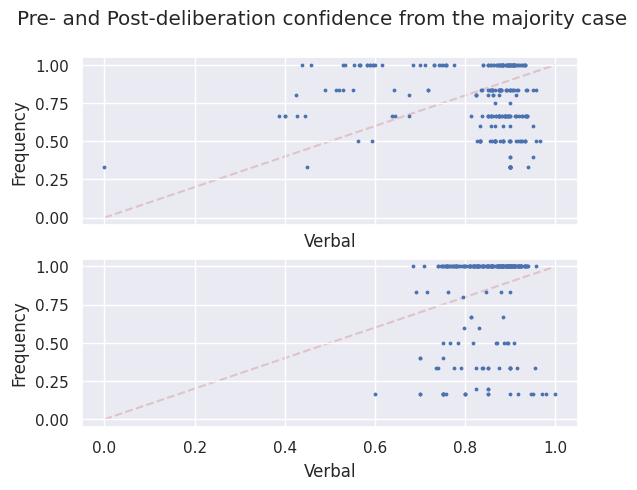

<Figure size 640x480 with 0 Axes>

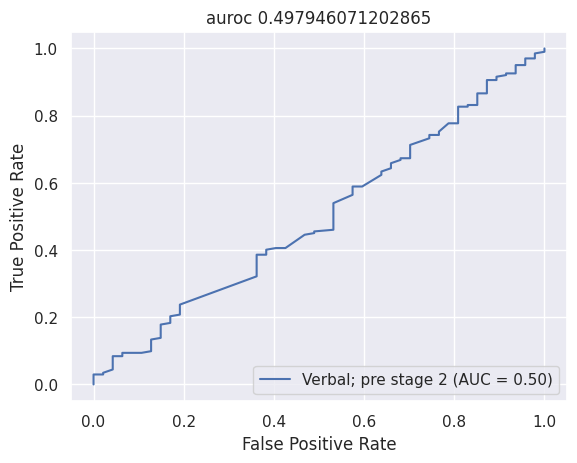

<Figure size 640x480 with 0 Axes>

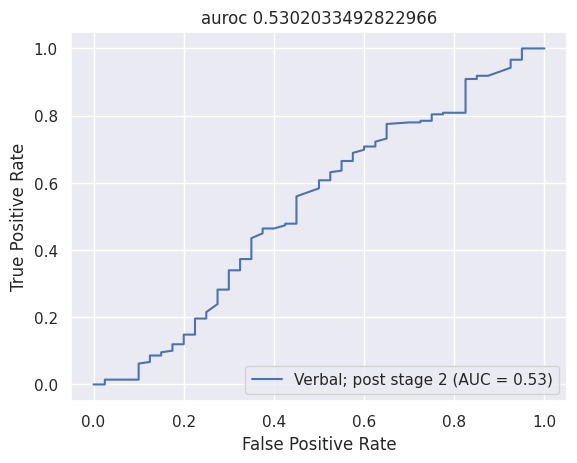

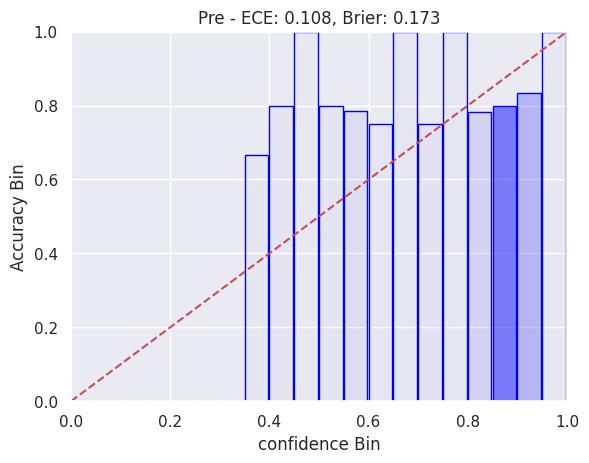

In [12]:
deliberation_ablation(dataset="dateUnd", fpath="dateUnd.jsonl")

##### GSM8K

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [24:05<00:00,  4.82s/it]   

test run mean accuracy 0.707, mean confidence 0.766
maj1@6(0-shot) mean accuracy 0.267, mean confidence 0.913


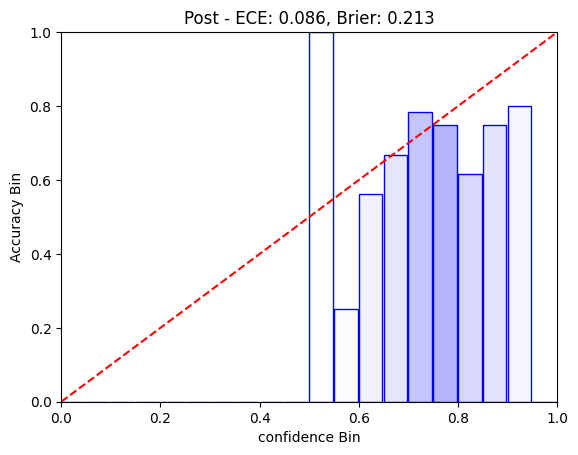

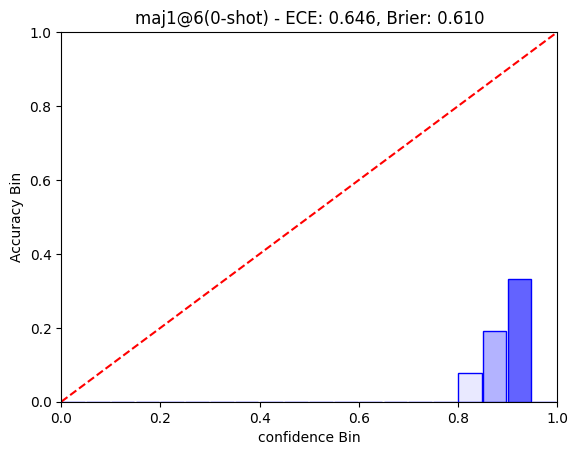

In [11]:
get_ece(dataset="gsm8k-test", fpath="gsm8k-test-300.jsonl", zs_baseline=True, zs_consistency_n=6)

in total 300 examples


100%|██████████| 300/300 [08:49<00:00,  1.76s/it]

number of unique stances pre stage 2: 3.217, post stage 2: 1.917
majority vote mean confidence pre stage 2: 0.669, post stage 2: 0.762
non-majority mean confidence pre stage 2: 0.734, post stage 2: 0.771
early consensus rate: 0.027; early consensus being correct 100.00% of the time, with avg confidence boost: 0.53%
majority change rate: 0.357; effective rate (changing from incorrect to correct): 32.71% of the time.
compare between pre and post stance distributions - Wasserstein: 1.155 KL: 0.728


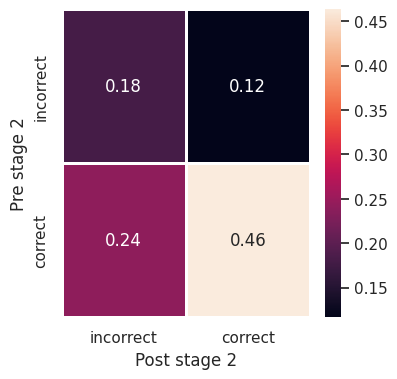

<Figure size 640x480 with 0 Axes>

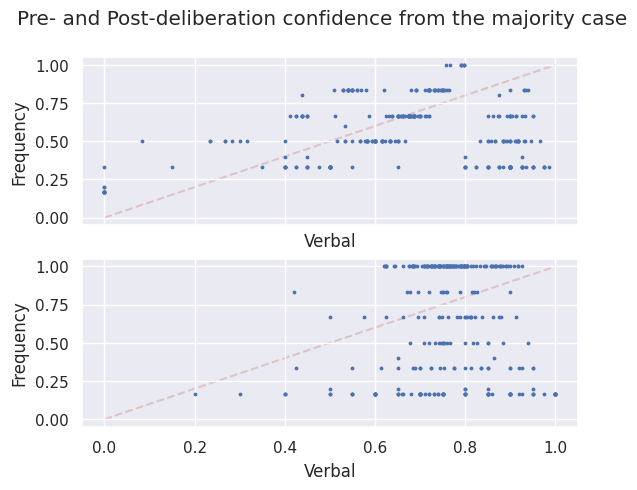

<Figure size 640x480 with 0 Axes>

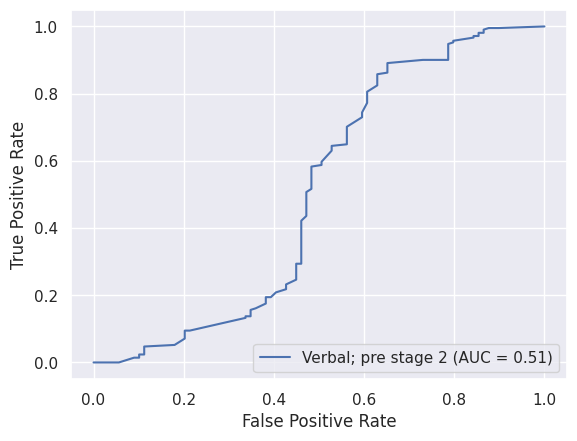

<Figure size 640x480 with 0 Axes>

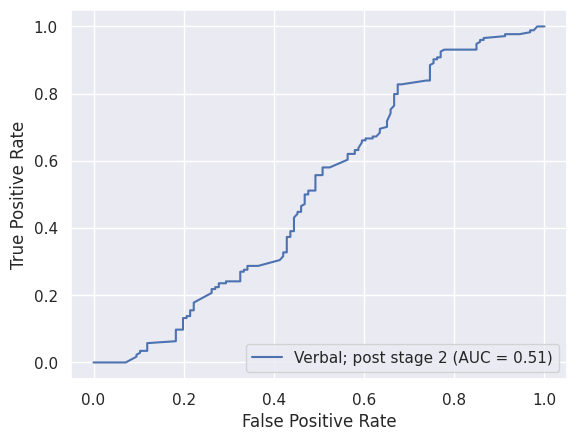

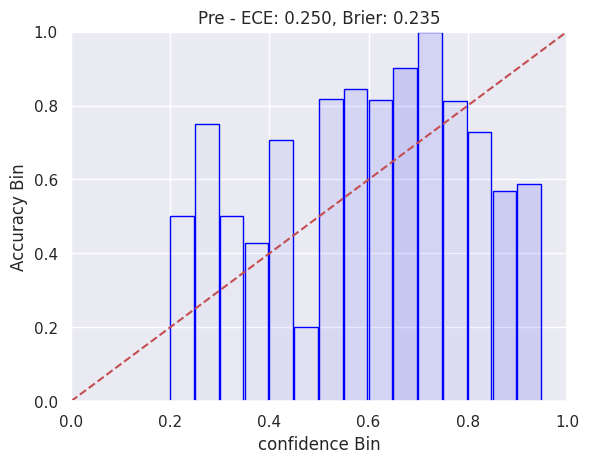

In [19]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test-300.jsonl")

##### TriviaQA

100%|██████████| 300/300 [18:07<00:00,  3.62s/it]

test run mean accuracy 0.937, mean confidence 0.872
maj1@6(0-shot) mean accuracy 0.950, mean confidence 0.899


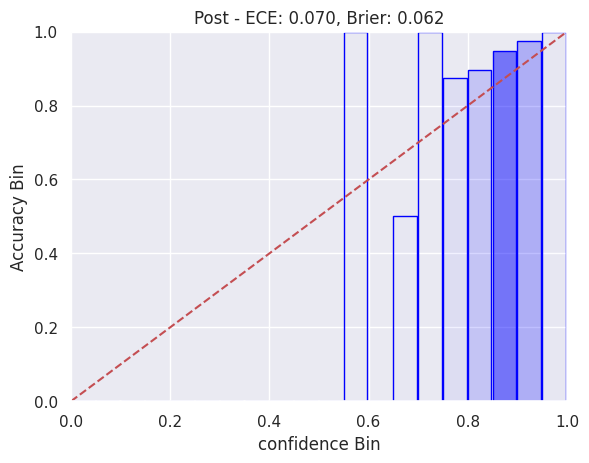

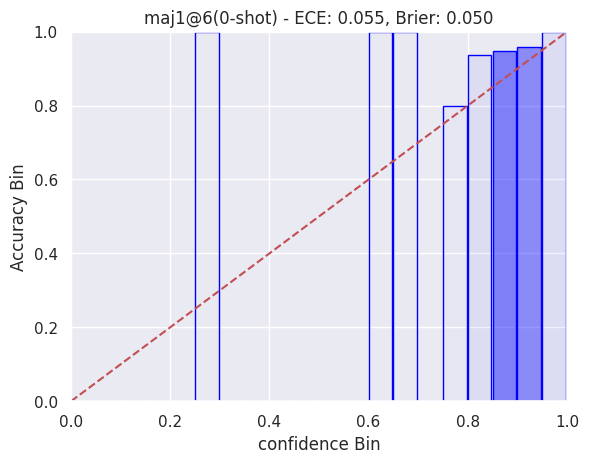

In [16]:
get_ece(dataset="triviaqa-dev", fpath="triviaqa-dev-300.jsonl", zs_baseline=True, zs_consistency_n=6)

in total 300 examples


100%|██████████| 300/300 [07:32<00:00,  1.51s/it]

number of unique stances pre stage 2: 1.873, post stage 2: 1.330
majority vote mean confidence pre stage 2: 0.797, post stage 2: 0.874
non-majority mean confidence pre stage 2: 0.795, post stage 2: 0.873
early consensus rate: 0.483; early consensus being correct 97.93% of the time, with avg confidence boost: 8.42%
majority change rate: 0.073; effective rate (changing from incorrect to correct): 40.91% of the time.
compare between pre and post stance distributions - Wasserstein: 1.041 KL: 0.501


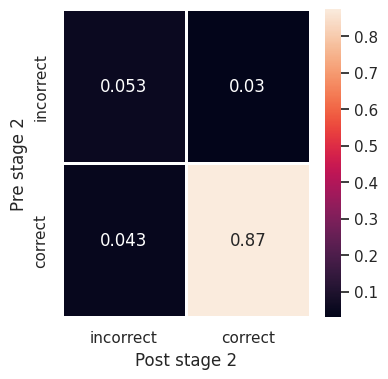

<Figure size 640x480 with 0 Axes>

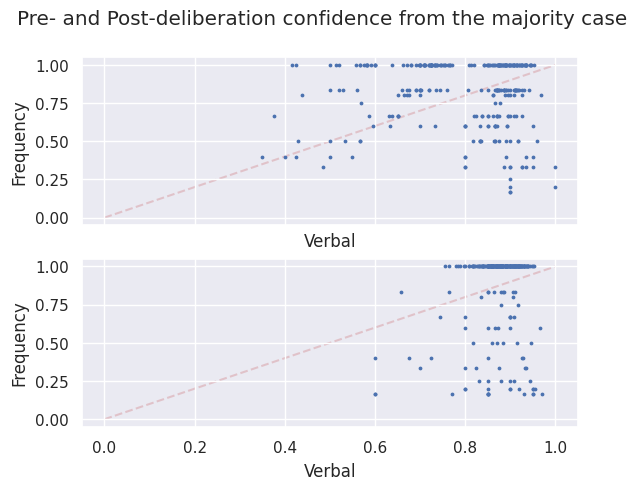

<Figure size 640x480 with 0 Axes>

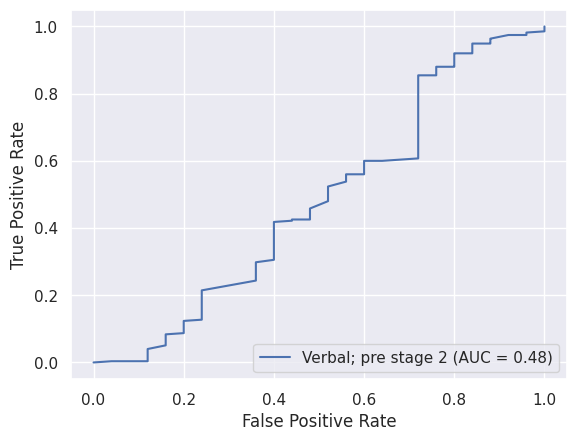

<Figure size 640x480 with 0 Axes>

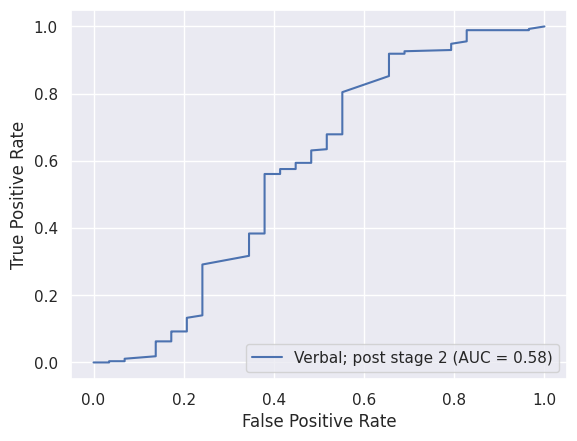

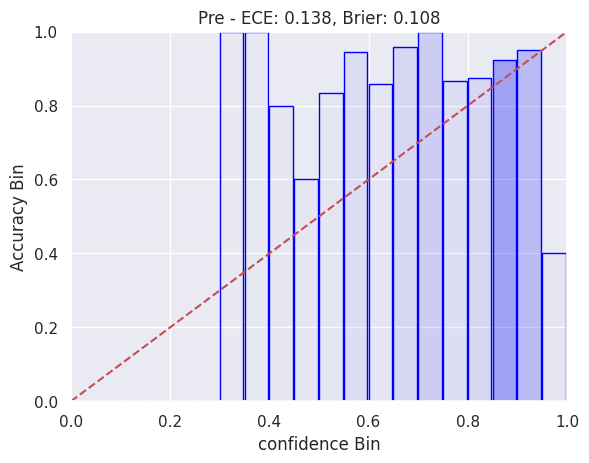

In [17]:
deliberation_ablation(dataset="triviaqa-dev", fpath="triviaqa-dev-300.jsonl")

##### SciQ

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [18:17<00:00,  3.66s/it]

test run mean accuracy 0.847, mean confidence 0.854
maj1@6(0-shot) mean accuracy 0.887, mean confidence 0.896


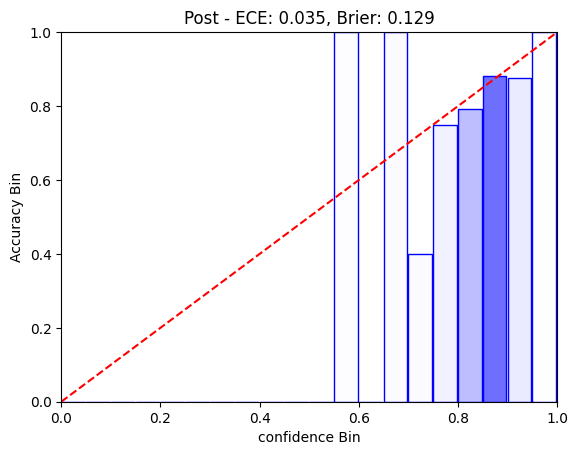

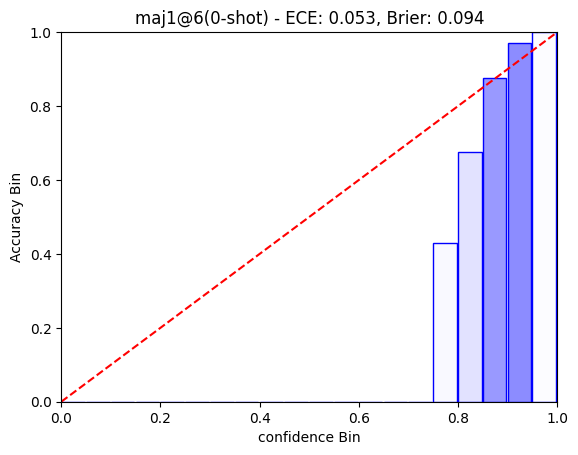

In [20]:
get_ece(dataset="sciq-valid", fpath="sciq-valid-300.jsonl", zs_baseline=True, zs_consistency_n=6)

in total 300 examples


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [04:20<00:00,  1.15it/s]

number of unique stances pre stage 2: 1.617, post stage 2: 1.233
majority vote mean confidence pre stage 2: 0.725, post stage 2: 0.855
non-majority mean confidence pre stage 2: 0.746, post stage 2: 0.855
early consensus rate: 0.573; early consensus being correct 97.09% of the time, with avg confidence boost: 12.49%
majority change rate: 0.090; effective rate (changing from incorrect to correct): 25.93% of the time.
compare between pre and post stance distributions - Wasserstein: 1.089 KL: 0.646


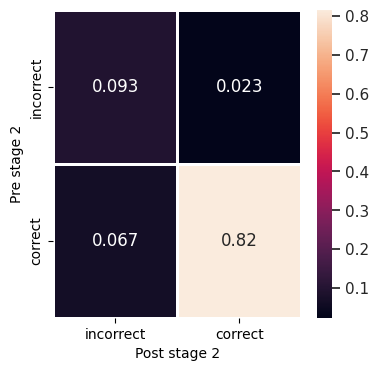

<Figure size 640x480 with 0 Axes>

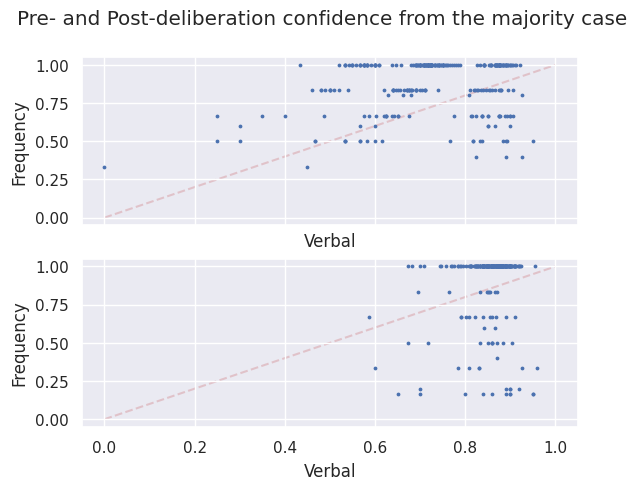

<Figure size 640x480 with 0 Axes>

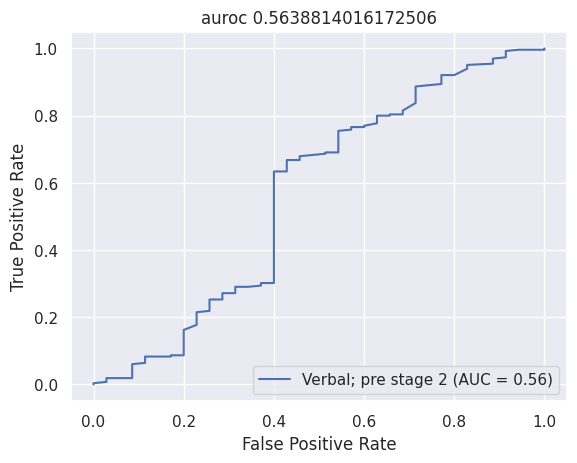

<Figure size 640x480 with 0 Axes>

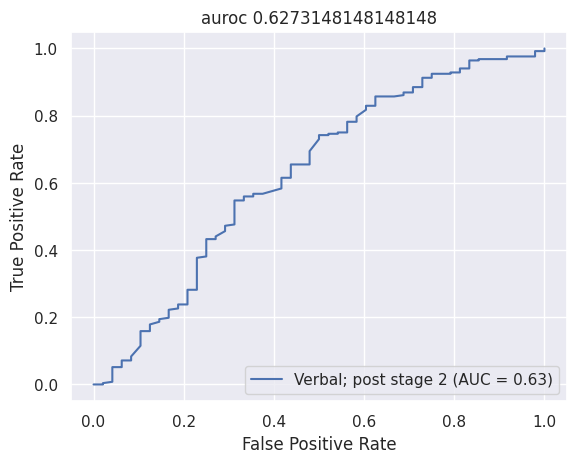

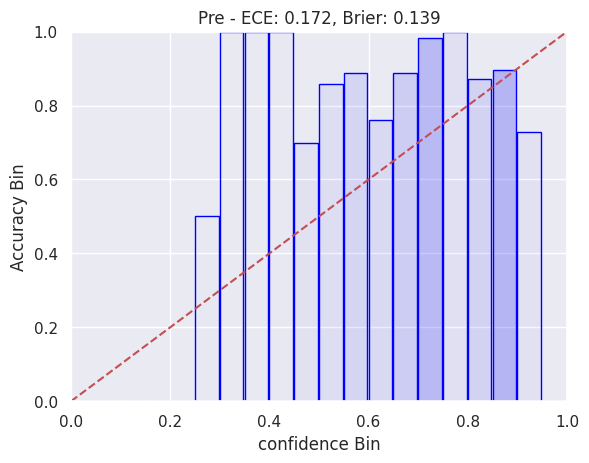

In [11]:
deliberation_ablation(dataset="sciq-valid", fpath="sciq-valid-300.jsonl")

##### AmbigQA

100%|██████████| 299/299 [19:25<00:00,  3.90s/it]

test run mean accuracy 0.853, mean confidence 0.852
maj1@6(0-shot) mean accuracy 0.873, mean confidence 0.871


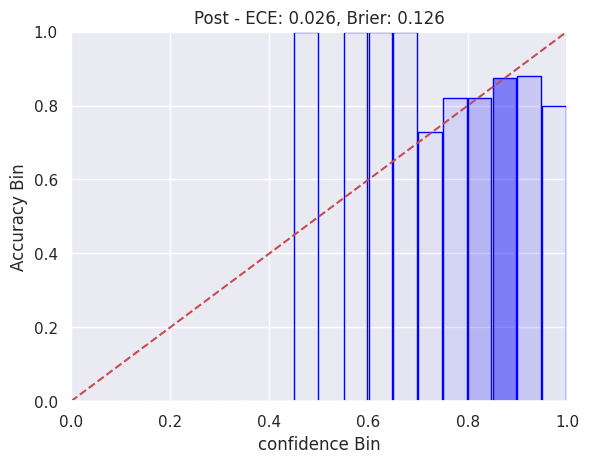

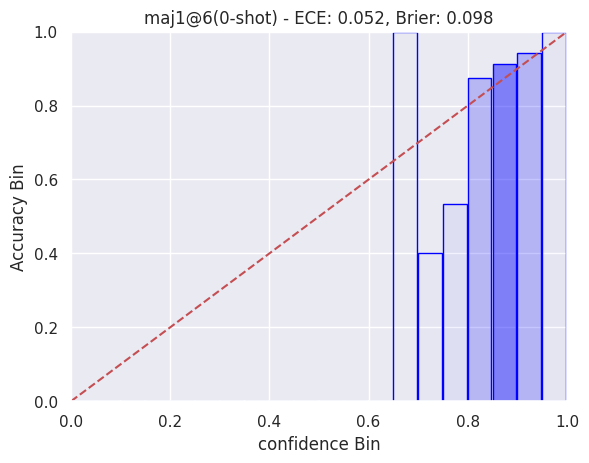

In [13]:
get_ece(dataset="ambigqa", fpath="ambigqa-300.jsonl", zs_baseline=True, zs_consistency_n=6)

in total 299 examples


100%|██████████| 299/299 [09:33<00:00,  1.92s/it]

number of unique stances pre stage 2: 2.535, post stage 2: 1.579
majority vote mean confidence pre stage 2: 0.756, post stage 2: 0.851
non-majority mean confidence pre stage 2: 0.781, post stage 2: 0.842
early consensus rate: 0.204; early consensus being correct 96.72% of the time, with avg confidence boost: 10.35%
majority change rate: 0.134; effective rate (changing from incorrect to correct): 57.50% of the time.
compare between pre and post stance distributions - Wasserstein: 0.999 KL: 0.633


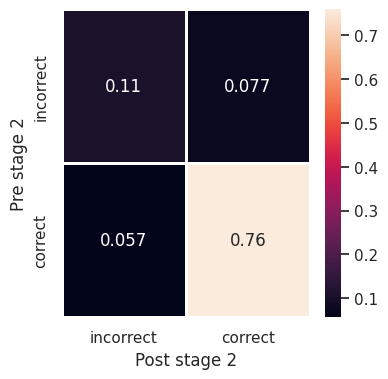

<Figure size 640x480 with 0 Axes>

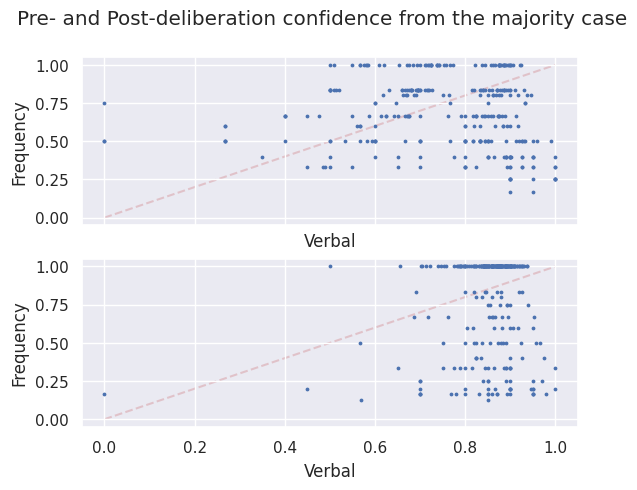

<Figure size 640x480 with 0 Axes>

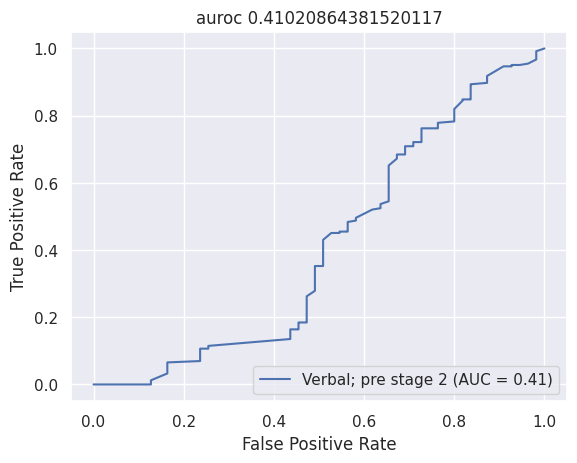

<Figure size 640x480 with 0 Axes>

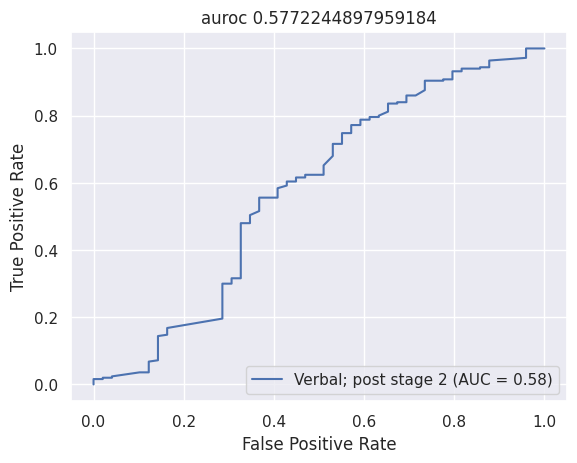

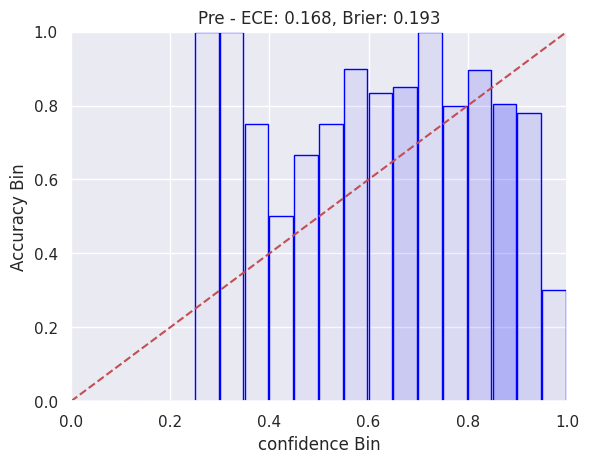

In [14]:
deliberation_ablation(dataset="ambigqa", fpath="ambigqa-300.jsonl")

### Explorations and tests for design choices

##### Search agent debug

in total 100 examples


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

number of unique stances pre stage 2: 1.230, post stage 2: 1.160
majority vote mean confidence pre stage 2: 0.872, post stage 2: 0.865
non-majority mean confidence pre stage 2: 0.854, post stage 2: 0.866
early consensus rate: 0.820; early consensus being correct 98.78% of the time, with avg confidence boost: 0.36%
majority change rate: 0.070; effective rate (changing from incorrect to correct): 42.86% of the time.
compare between pre and post stance distributions - Wasserstein: 1.000 KL: 0.565


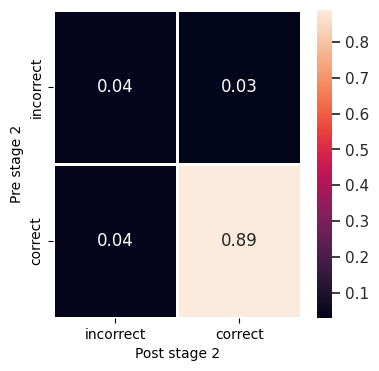

<Figure size 640x480 with 0 Axes>

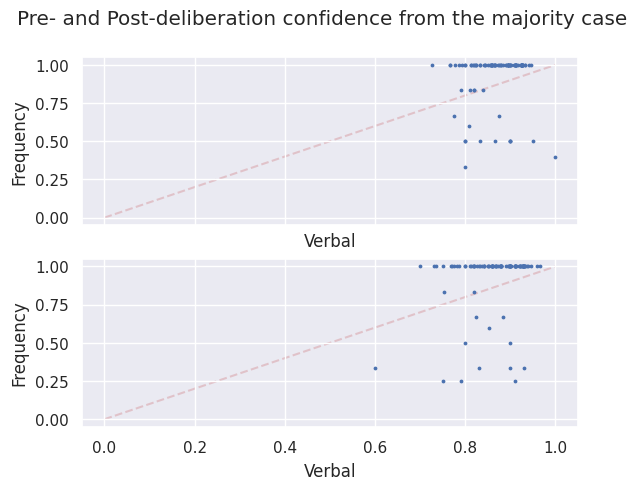

<Figure size 640x480 with 0 Axes>

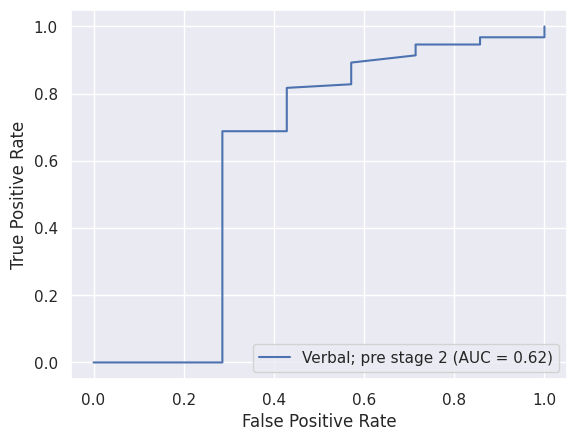

<Figure size 640x480 with 0 Axes>

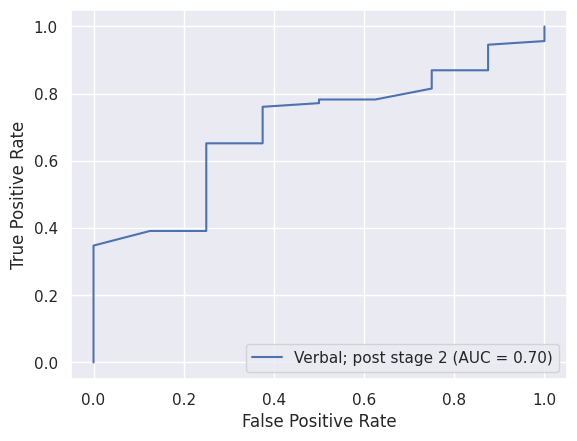

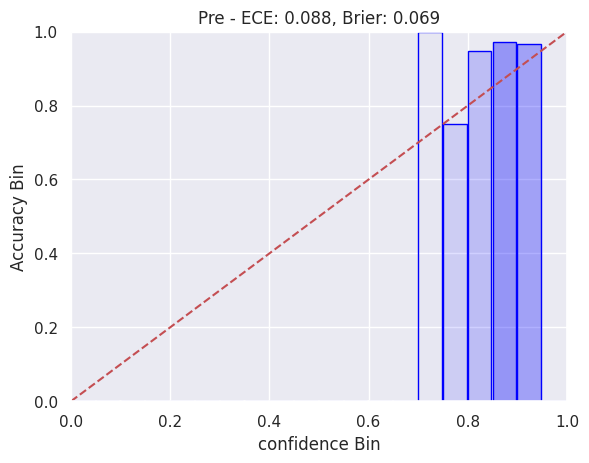

In [14]:
deliberation_ablation(dataset="triviaqa-dev", fpath="triviaqa-dev-search-100.jsonl")

100%|██████████| 100/100 [02:01<00:00,  1.21s/it]

test run mean accuracy 0.970, mean confidence 0.869
greedy(0-shot) mean accuracy 0.920, mean confidence 0.900


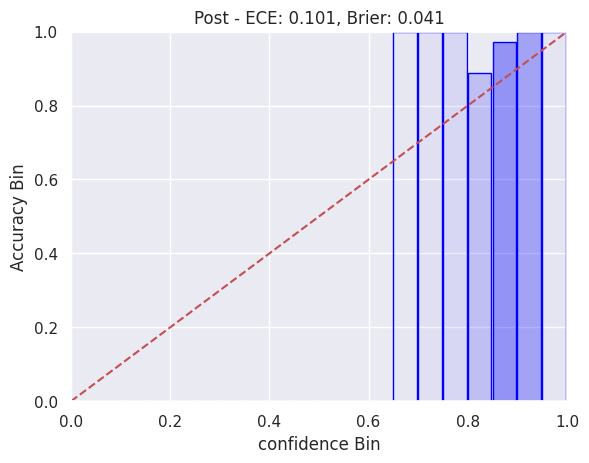

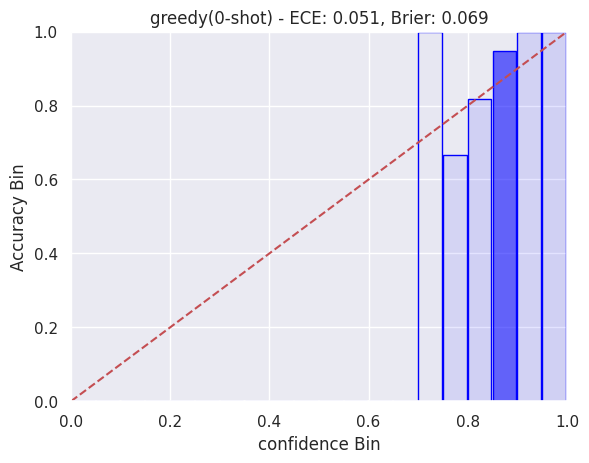

In [15]:
get_ece(dataset="triviaqa-dev", fpath="triviaqa-dev-search-100.jsonl", zs_baseline=True, zs_consistency_n=1)

####  the number of deliberators and raters
Tested on GSM8K, group-size 3, 6, 9 and raters (1+1), (2+2)

##### 3 deliberators, raters: pos 1, neg 1

in total 100 examples


100%|██████████| 100/100 [01:19<00:00,  1.27it/s]

number of unique stances pre stage 2: 1.850, post stage 2: 1.360
majority vote mean confidence pre stage 2: 0.840, post stage 2: 0.834
non-majority mean confidence pre stage 2: 0.786, post stage 2: 0.829
early consensus rate: 0.360; early consensus being correct 91.67% of the time, with avg confidence boost: 13.98%
majority change rate: 0.250; effective rate (changing from incorrect to correct): 56.00% of the time.
compare between pre and post stance distributions - Wasserstein: 0.762 KL: 0.596


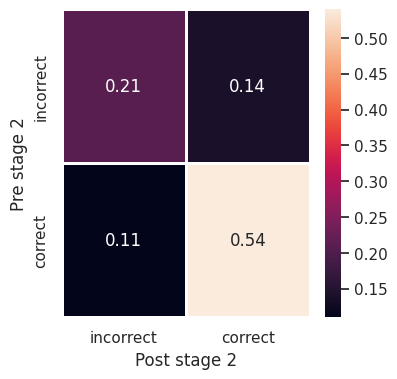

<Figure size 640x480 with 0 Axes>

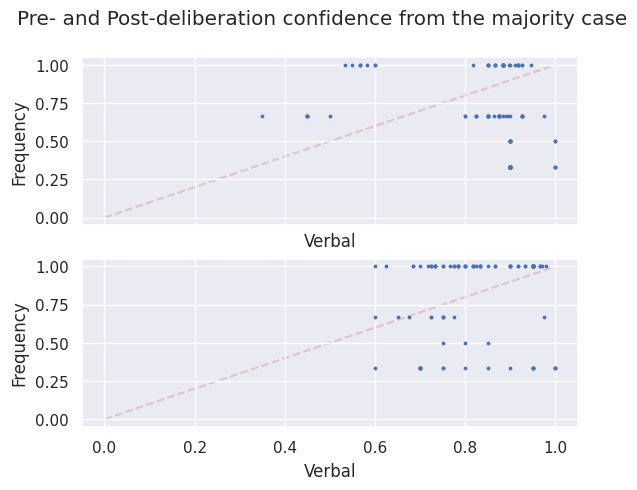

<Figure size 640x480 with 0 Axes>

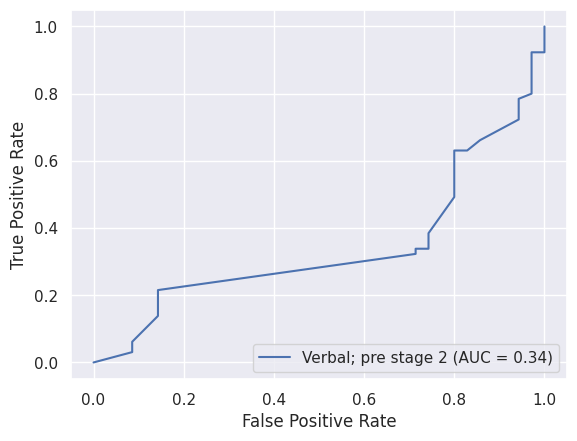

<Figure size 640x480 with 0 Axes>

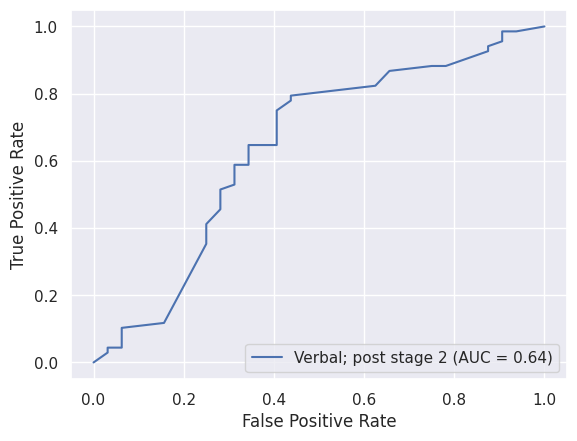

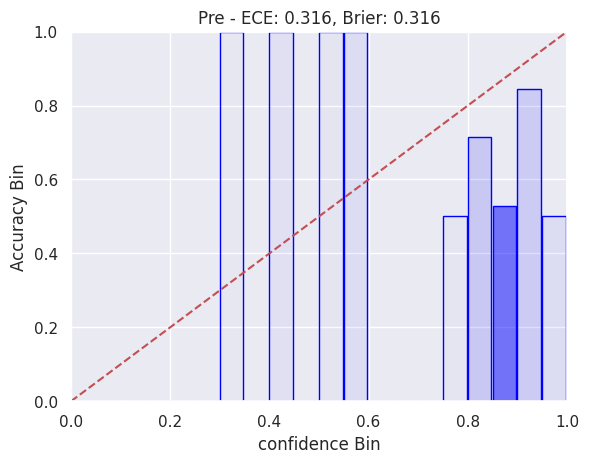

In [30]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test-3.jsonl")

  0%|          | 0/100 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [01:42<01:25,  1.91s/it]

wrong ans format: Jewelry, []


100%|██████████| 100/100 [02:57<00:00,  1.78s/it]

test run mean accuracy 0.690, mean confidence 0.829
maj1@3(0-shot) mean accuracy 0.250, mean confidence 0.912


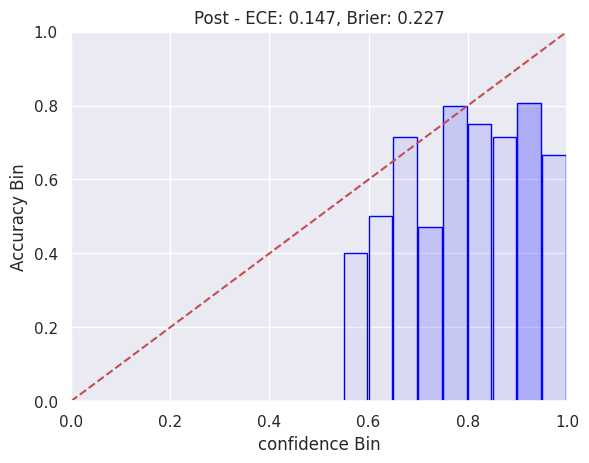

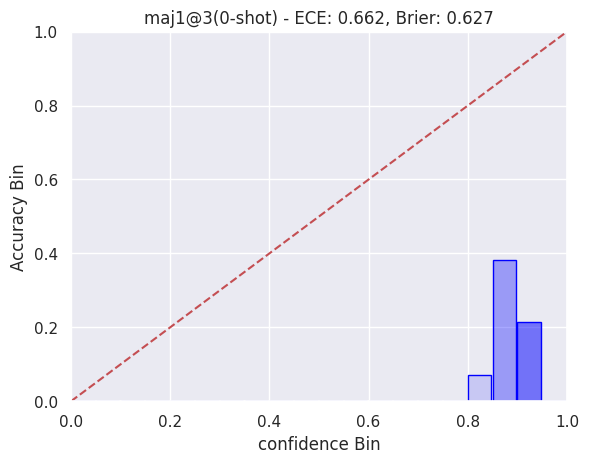

In [98]:
get_ece(dataset="gsm8k-test", fpath="gsm8k-test-3.jsonl", zs_baseline=True, zs_consistency_n=3)

##### 3 deliberators, pos/neg raters: 2 + 2

in total 100 examples


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

number of unique stances pre stage 2: 2.050, post stage 2: 1.410
majority vote mean confidence pre stage 2: 0.461, post stage 2: 0.778
non-majority mean confidence pre stage 2: 0.649, post stage 2: 0.780
early consensus rate: 0.270; early consensus being correct 92.59% of the time, with avg confidence boost: 26.73%
majority change rate: 0.360; effective rate (changing from incorrect to correct): 58.33% of the time.
compare between pre and post stance distributions - Wasserstein: 0.848 KL: 0.644


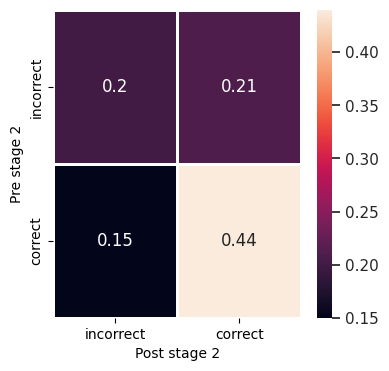

<Figure size 640x480 with 0 Axes>

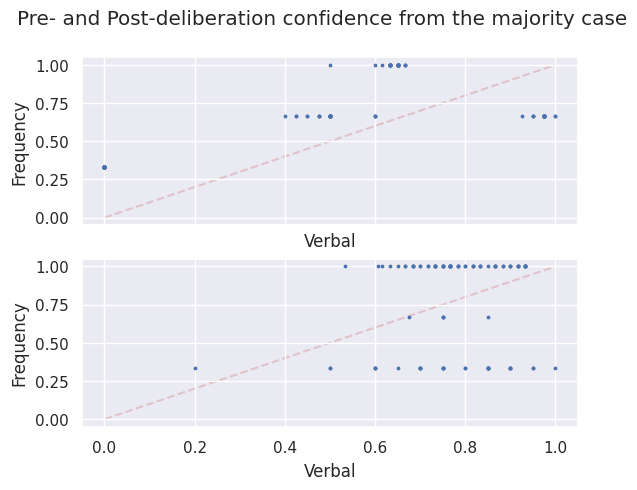

<Figure size 640x480 with 0 Axes>

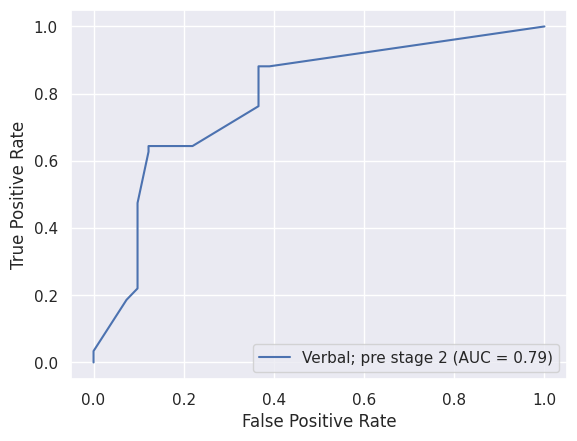

<Figure size 640x480 with 0 Axes>

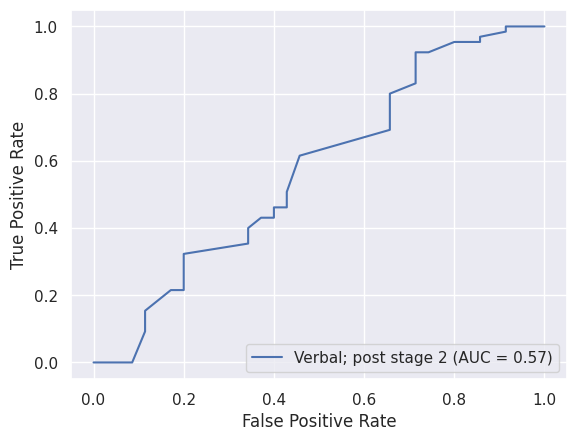

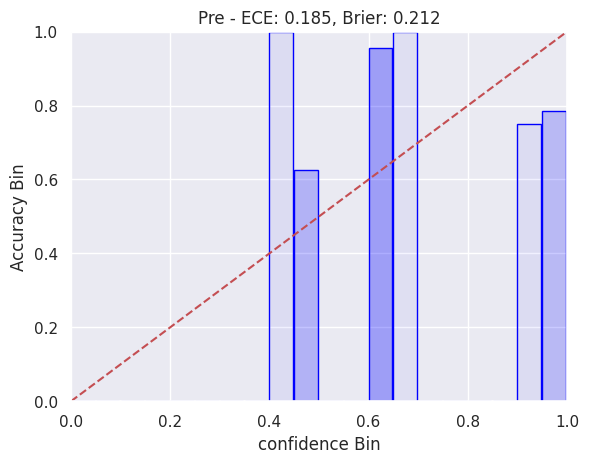

In [28]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test-3-2.jsonl")

100%|██████████| 100/100 [03:08<00:00,  1.88s/it]

test run mean accuracy 0.620, mean confidence 0.779
maj1@3(0-shot) mean accuracy 0.240, mean confidence 0.912


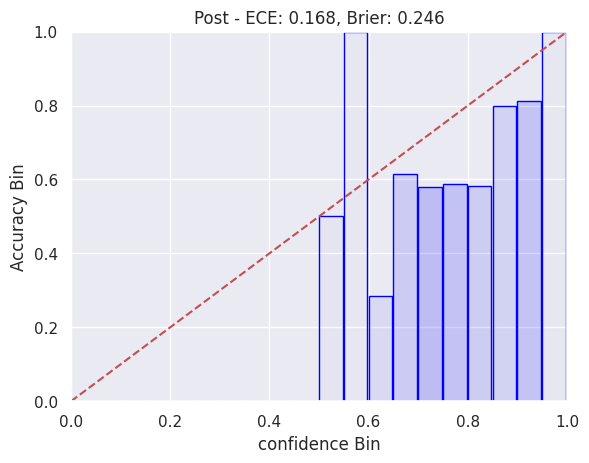

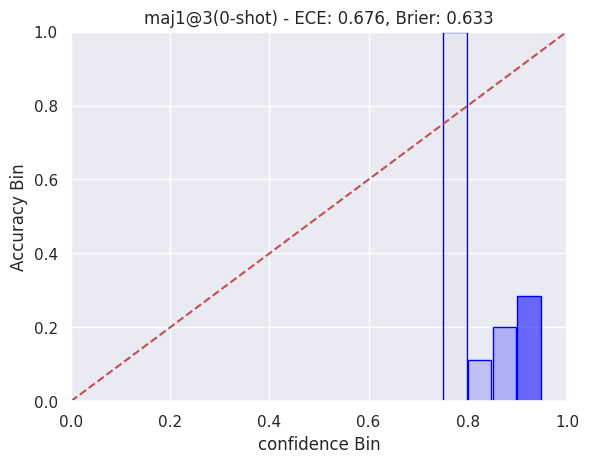

In [100]:
get_ece(dataset="gsm8k-test", fpath="gsm8k-test-3-2.jsonl", zs_baseline=True, zs_consistency_n=3)

##### 6 deliberators, pos/neg raters: 1 + 1

in total 100 examples


100%|██████████| 100/100 [03:44<00:00,  2.24s/it]

number of unique stances pre stage 2: 2.930, post stage 2: 1.930
majority vote mean confidence pre stage 2: 0.857, post stage 2: 0.761
non-majority mean confidence pre stage 2: 0.849, post stage 2: 0.762
early consensus rate: 0.050; early consensus being correct 100.00% of the time, with avg confidence boost: 12.34%
majority change rate: 0.290; effective rate (changing from incorrect to correct): 37.93% of the time.
compare between pre and post stance distributions - Wasserstein: 1.285 KL: 0.646


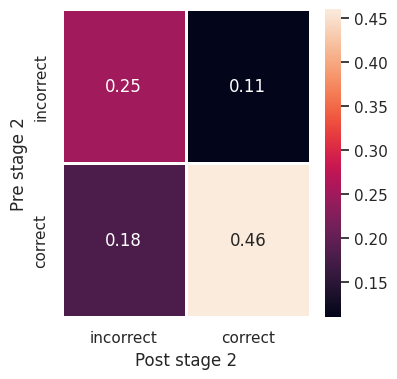

<Figure size 640x480 with 0 Axes>

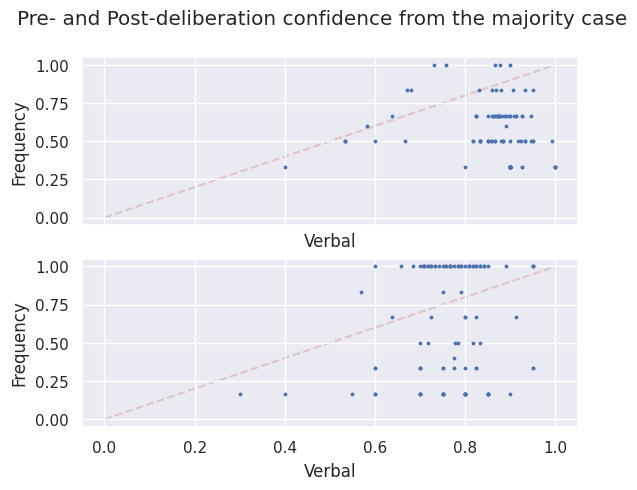

<Figure size 640x480 with 0 Axes>

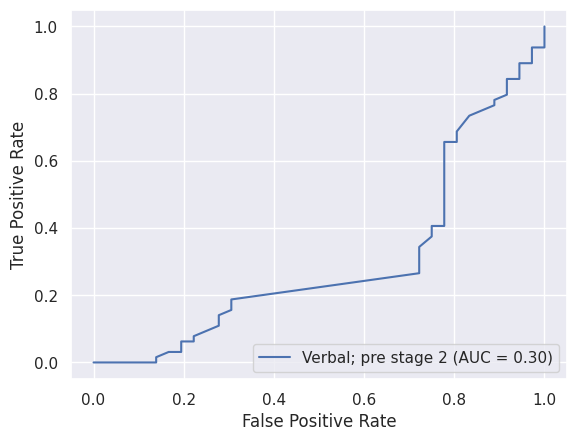

<Figure size 640x480 with 0 Axes>

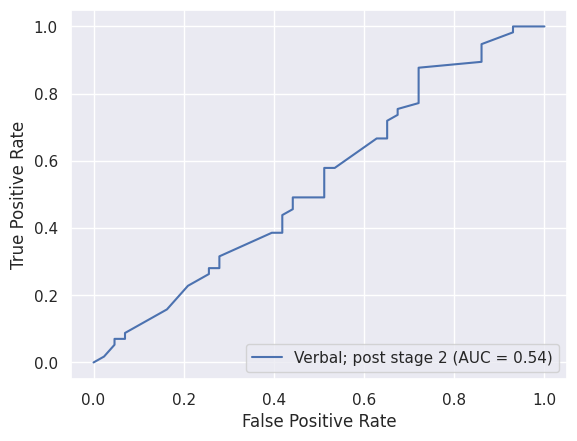

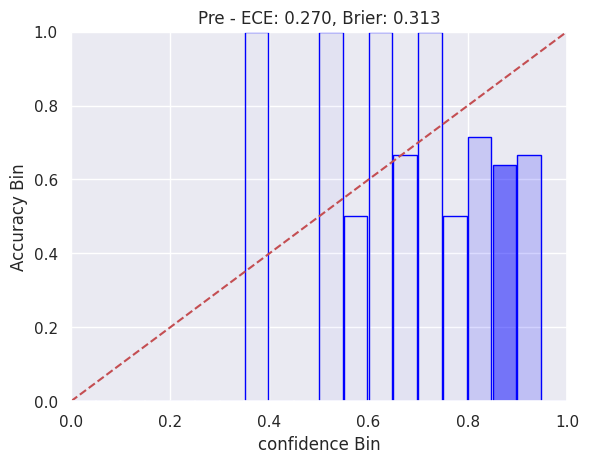

In [101]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test-6.jsonl")

 72%|███████▏  | 72/100 [03:53<01:24,  3.02s/it]

wrong ans format: , []


100%|██████████| 100/100 [05:21<00:00,  3.22s/it]

test run mean accuracy 0.670, mean confidence 0.766
maj1@6(0-shot) mean accuracy 0.260, mean confidence 0.912


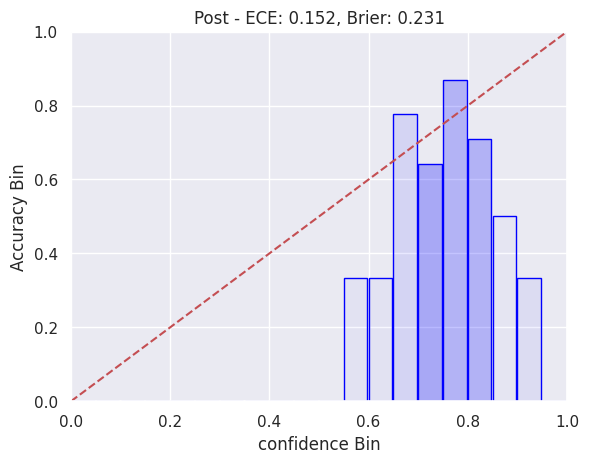

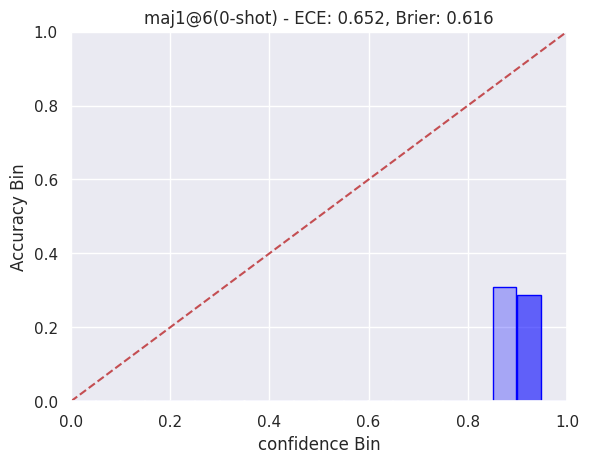

In [102]:
get_ece(dataset="gsm8k-test", fpath="gsm8k-test-6.jsonl", zs_baseline=True, zs_consistency_n=6)

##### 6 deliberators, pos/neg raters: 2 + 2

in total 100 examples


100%|██████████| 100/100 [03:09<00:00,  1.90s/it]

number of unique stances pre stage 2: 2.720, post stage 2: 1.840
majority vote mean confidence pre stage 2: 0.847, post stage 2: 0.814
non-majority mean confidence pre stage 2: 0.802, post stage 2: 0.791
early consensus rate: 0.210; early consensus being correct 100.00% of the time, with avg confidence boost: 0.38%
majority change rate: 0.180; effective rate (changing from incorrect to correct): 50.00% of the time.
compare between pre and post stance distributions - Wasserstein: 1.164 KL: 0.673


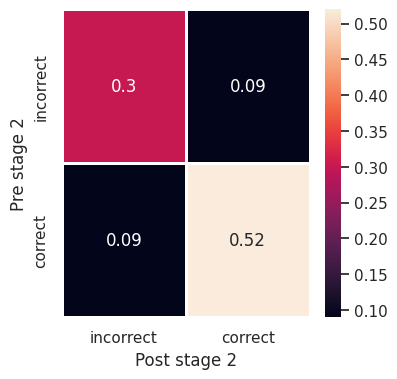

<Figure size 640x480 with 0 Axes>

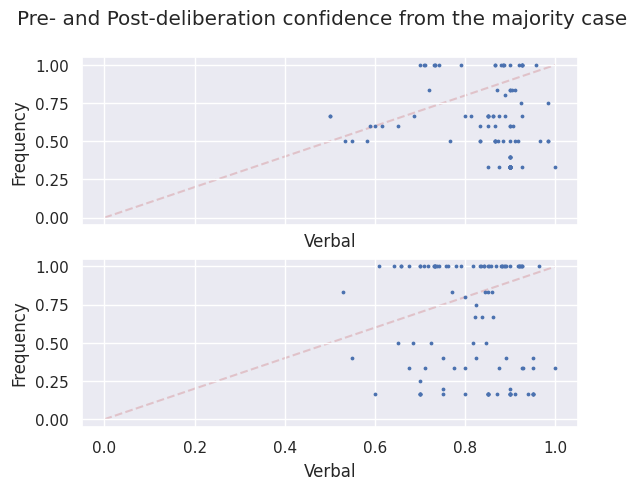

<Figure size 640x480 with 0 Axes>

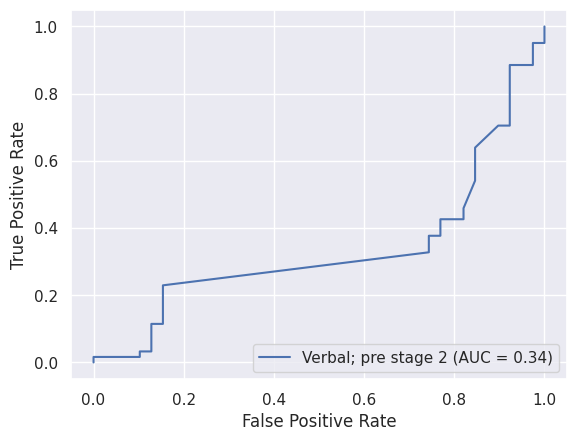

<Figure size 640x480 with 0 Axes>

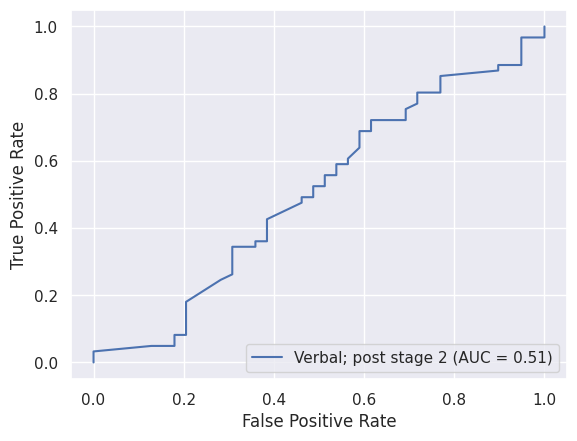

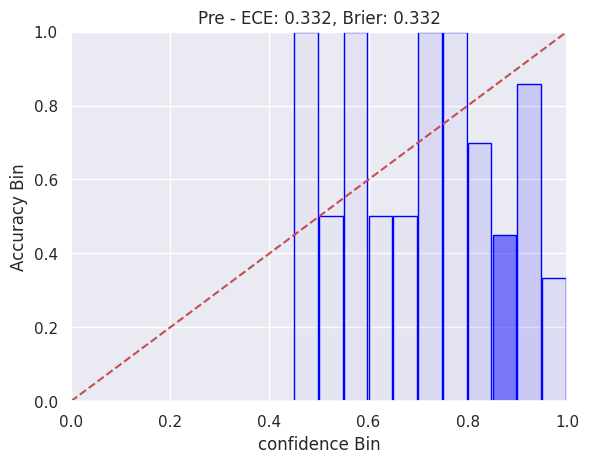

In [103]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test-6-2.jsonl")

 33%|███▎      | 33/100 [01:42<03:33,  3.18s/it]

wrong ans format: , []


100%|██████████| 100/100 [05:11<00:00,  3.11s/it]

test run mean accuracy 0.630, mean confidence 0.795
maj1@6(0-shot) mean accuracy 0.270, mean confidence 0.913


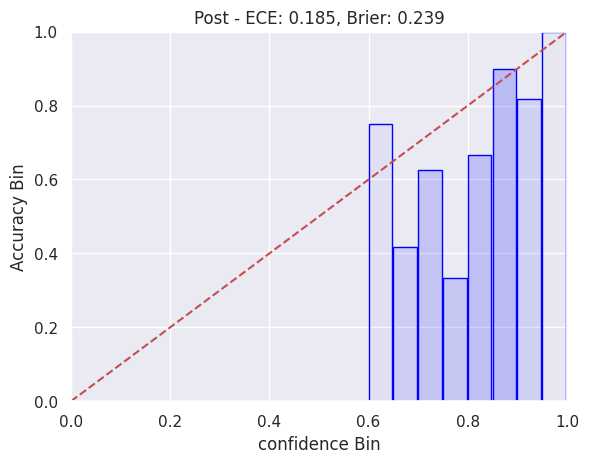

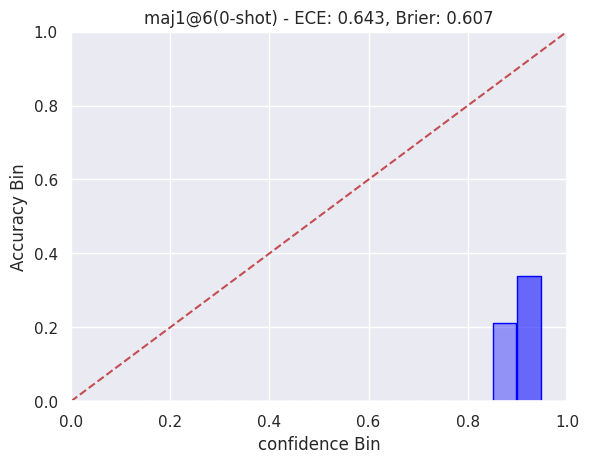

In [104]:
get_ece(dataset="gsm8k-test", fpath="gsm8k-test-6-2.jsonl", zs_baseline=True, zs_consistency_n=6)

##### 9 deliberators, pos/neg raters: 1 + 1

in total 100 examples


100%|██████████| 100/100 [03:39<00:00,  2.19s/it]

number of unique stances pre stage 2: 3.020, post stage 2: 1.910
majority vote mean confidence pre stage 2: 0.514, post stage 2: 0.755
non-majority mean confidence pre stage 2: 0.766, post stage 2: 0.751
early consensus rate: 0.120; early consensus being correct 100.00% of the time, with avg confidence boost: 27.69%
majority change rate: 0.370; effective rate (changing from incorrect to correct): 32.43% of the time.
compare between pre and post stance distributions - Wasserstein: 1.667 KL: 0.850


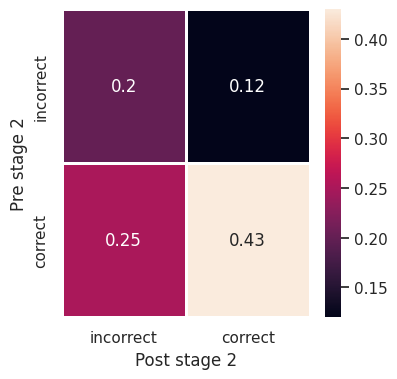

<Figure size 640x480 with 0 Axes>

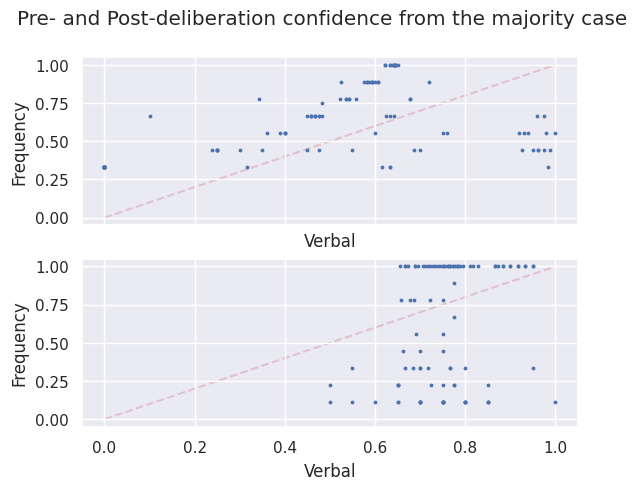

<Figure size 640x480 with 0 Axes>

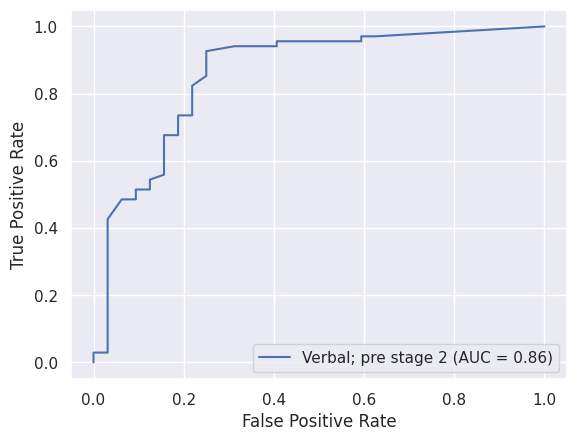

<Figure size 640x480 with 0 Axes>

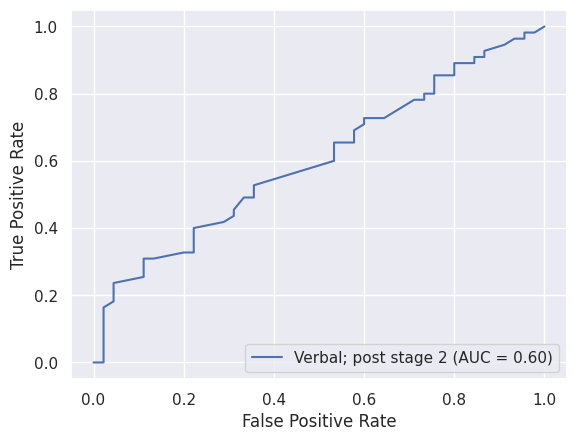

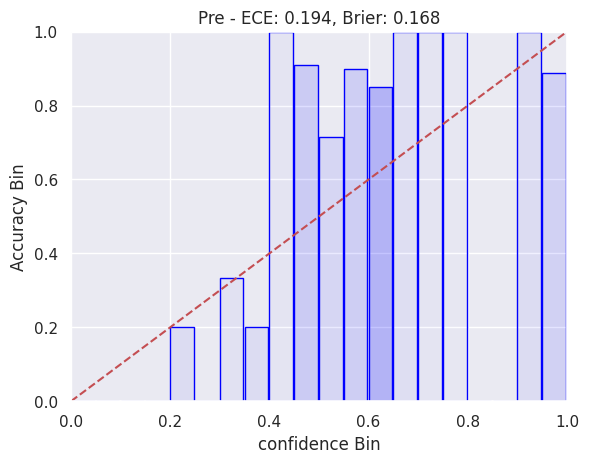

In [105]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test-9.jsonl")

  0%|          | 0/100 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [03:40<03:32,  4.17s/it]

wrong ans format: Electronics, []
wrong ans format: Jewelry, []


100%|██████████| 100/100 [07:35<00:00,  4.56s/it]

test run mean accuracy 0.640, mean confidence 0.752
maj1@9(0-shot) mean accuracy 0.320, mean confidence 0.909


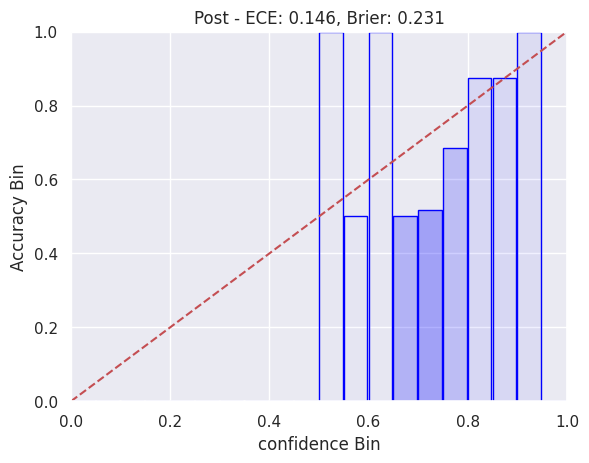

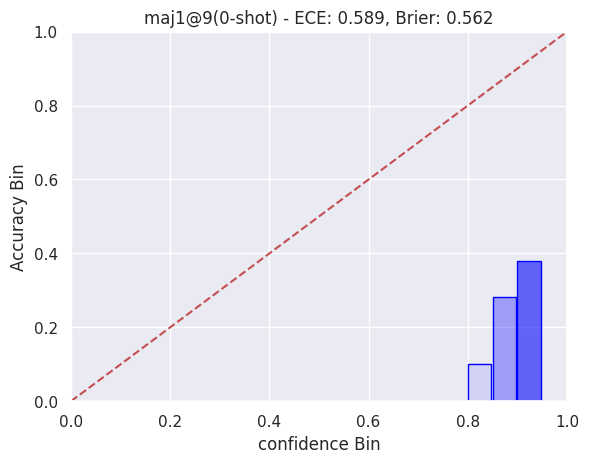

In [107]:
get_ece(dataset="gsm8k-test", fpath="gsm8k-test-9.jsonl", zs_baseline=True, zs_consistency_n=9)

##### 9 deliberators, pos/neg raters: 2 + 2

in total 100 examples


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]

number of unique stances pre stage 2: 2.960, post stage 2: 2.140
majority vote mean confidence pre stage 2: 0.599, post stage 2: 0.657
non-majority mean confidence pre stage 2: 0.767, post stage 2: 0.633
early consensus rate: 0.100; early consensus being correct 100.00% of the time, with avg confidence boost: 4.37%
majority change rate: 0.320; effective rate (changing from incorrect to correct): 28.12% of the time.
compare between pre and post stance distributions - Wasserstein: 1.531 KL: 0.783


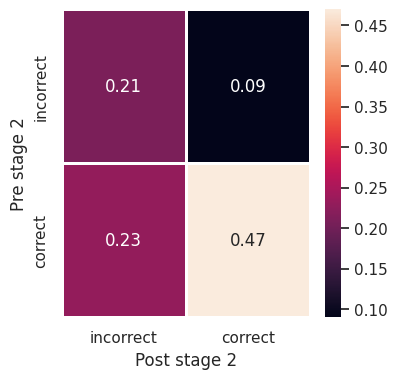

<Figure size 640x480 with 0 Axes>

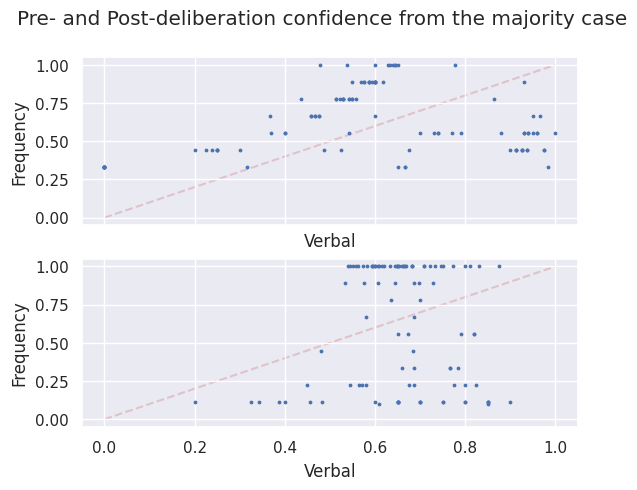

<Figure size 640x480 with 0 Axes>

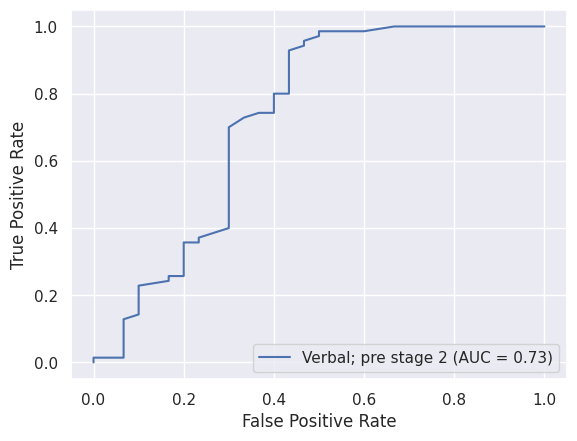

<Figure size 640x480 with 0 Axes>

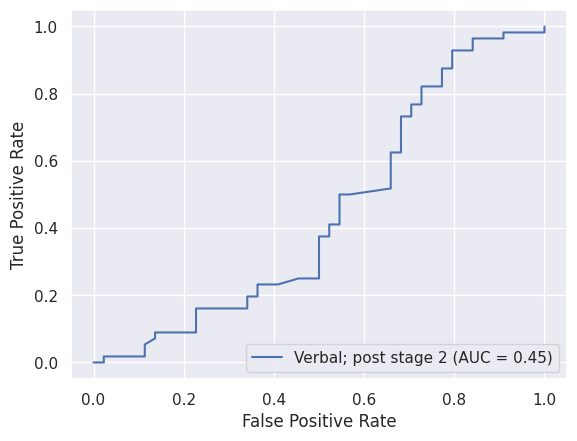

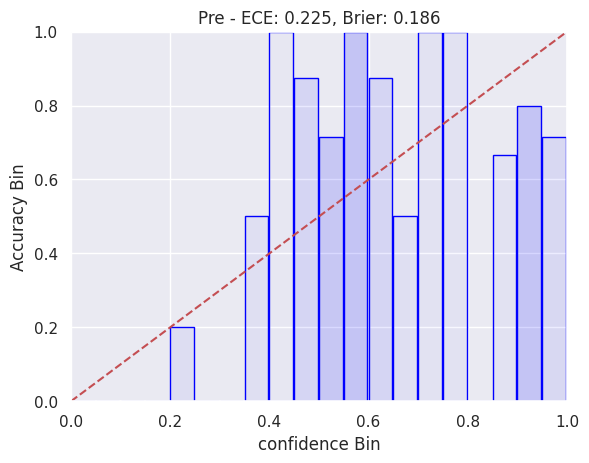

In [108]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test-9-2.jsonl")

100%|██████████| 100/100 [07:21<00:00,  4.41s/it]

test run mean accuracy 0.540, mean confidence 0.651
maj1@9(0-shot) mean accuracy 0.330, mean confidence 0.911


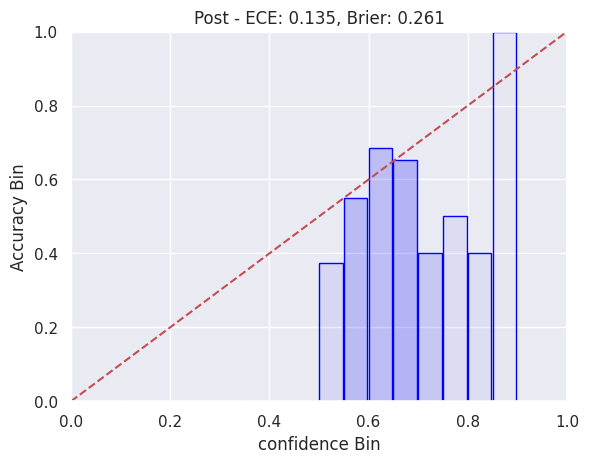

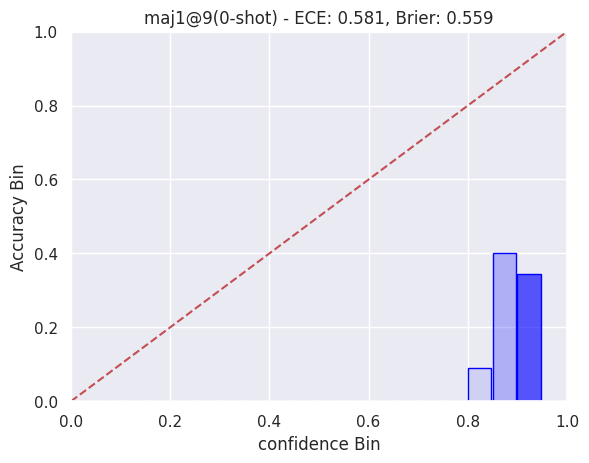

In [109]:
get_ece(dataset="gsm8k-test", fpath="gsm8k-test-9-2.jsonl", zs_baseline=True, zs_consistency_n=9)

#### **Compare pre- and post-deliberation votes, stances and confidence distribution**

Following Kuhn (2023), calculate AUROC as a metric (predict correctness based on confidence score) in addition to ECE and Brier (which might not be suitable for NLG).

in total 100 examples


100%|██████████| 100/100 [02:35<00:00,  1.55s/it]

number of unique stances pre stage 2: 2.740, post stage 2: 1.770
majority vote mean confidence pre stage 2: 0.882, post stage 2: 0.772
non-majority mean confidence pre stage 2: 0.873, post stage 2: 0.764
early consensus rate: 0.090; early consensus being correct 100.00% of the time, with avg confidence boost: 6.70%
majority change rate: 0.210; effective rate (changing from incorrect to correct): 52.38% of the time.
compare between pre and post stance distributions - Wasserstein: 1.339 KL: 0.613


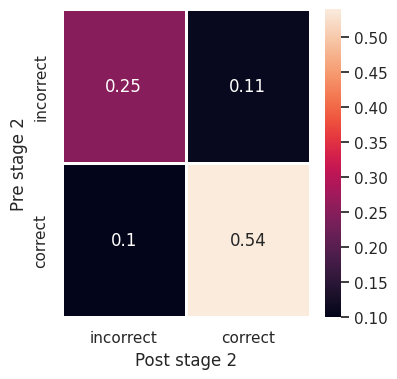

<Figure size 640x480 with 0 Axes>

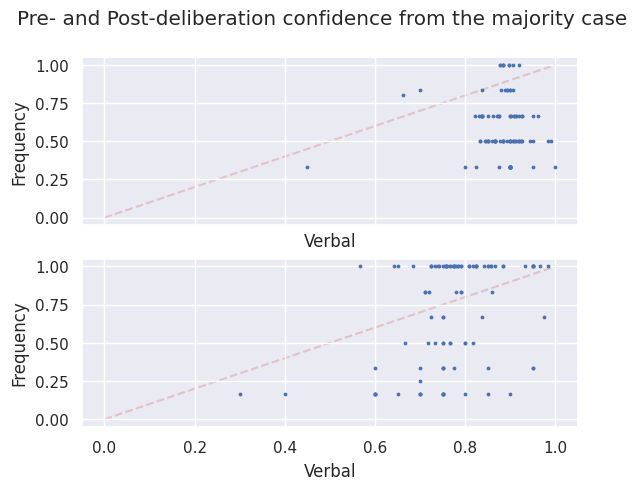

<Figure size 640x480 with 0 Axes>

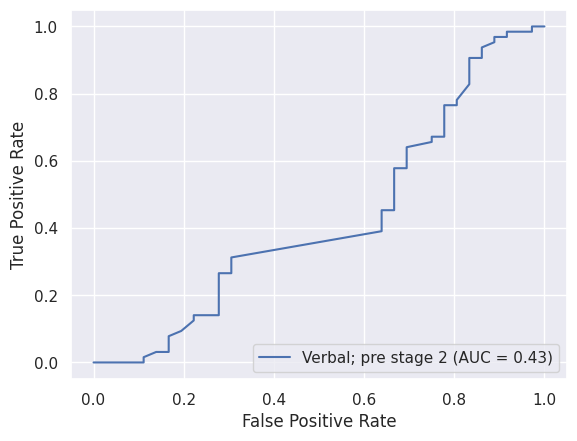

<Figure size 640x480 with 0 Axes>

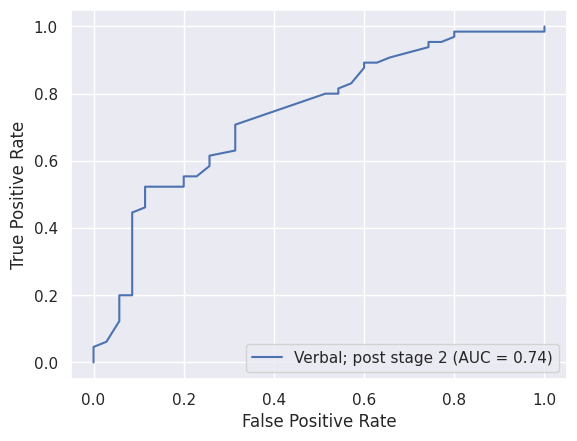

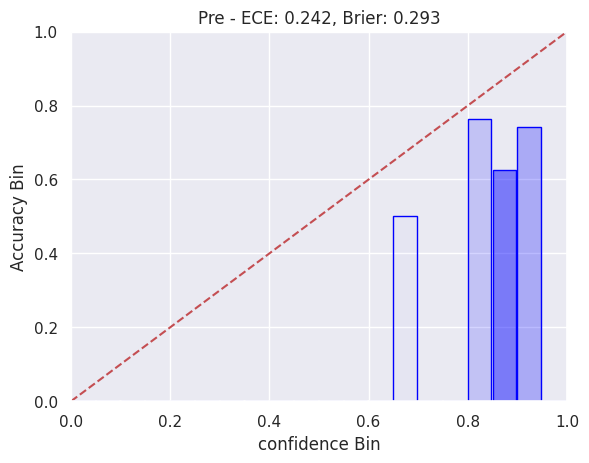

In [54]:
deliberation_ablation(dataset="gsm8k-test", fpath="gsm8k-test.jsonl")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

test run mean accuracy 0.680, mean confidence 0.780
0-shot mean accuracy 0.450, mean confidence 0.925


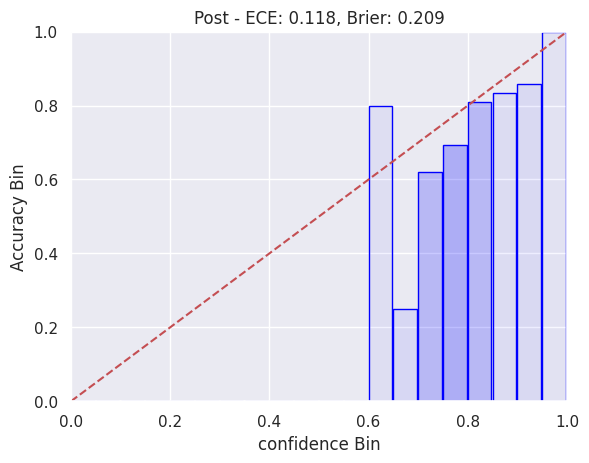

In [55]:
gsm8k_100_res, gsm8k_100_records = read_data(dataset="gsm8k-test", fpath="gsm8k-test.jsonl")
gsm8k_100_acc_all, gsm8k_100_conf_all, gsm8k_100_acc_all_zs, gsm8k_100_conf_all_zs, = get_acc_and_conf(gsm8k_100_res, gsm8k_100_records, zs_baseline=True)

ece, prop_all_bins, accuracy_all_bins, bin_boundaries = interval_ece(gsm8k_100_acc_all, gsm8k_100_conf_all)
bs = brier_score(gsm8k_100_acc_all, gsm8k_100_conf_all)
plot_reliability_diagram(bin_boundaries, prop_all_bins, accuracy_all_bins, f"Post - ECE: {ece:.3f}, Brier: {bs:.3f}")

in total 100 examples


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:40<00:00,  1.61s/it]

number of unique stances pre stage 2: 1.720, post stage 2: 1.270
majority vote mean confidence pre stage 2: 0.746, post stage 2: 0.868
non-majority mean confidence pre stage 2: 0.704, post stage 2: 0.868
early consensus rate: 0.500; early consensus being correct 94.00% of the time, with avg confidence boost: 20.41%
majority change rate: 0.130; effective rate (changing from incorrect to correct): 53.85% of the time.
compare between pre and post stance distributions - Wasserstein: 0.959 KL: 0.533


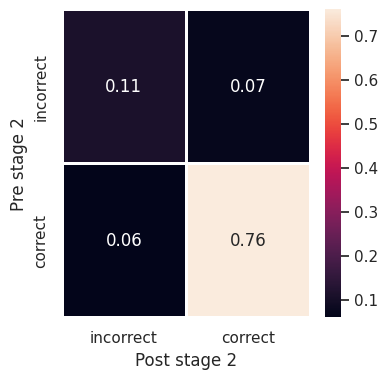

<Figure size 640x480 with 0 Axes>

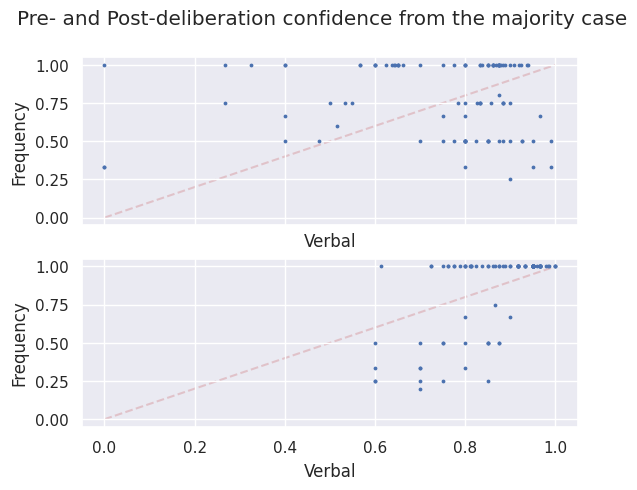

<Figure size 640x480 with 0 Axes>

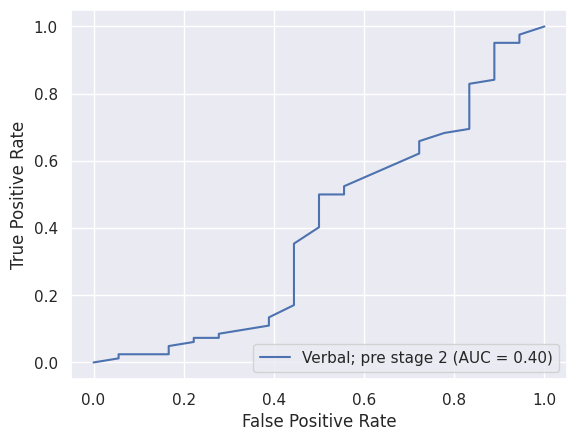

<Figure size 640x480 with 0 Axes>

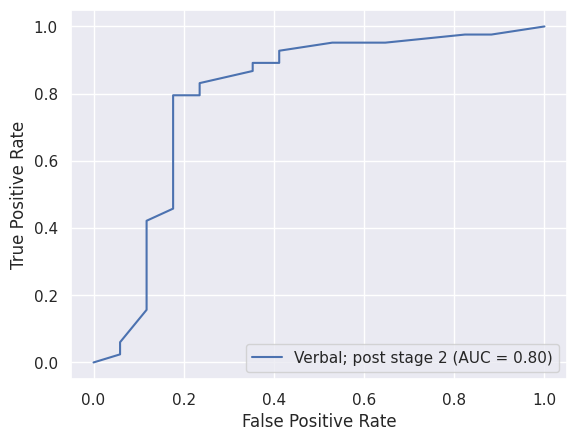

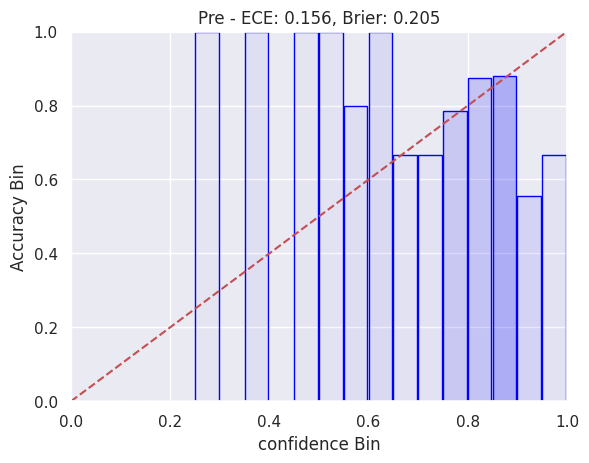

In [56]:
deliberation_ablation(dataset="ambigqa", fpath="ambigqa.jsonl")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:30<00:00,  1.10it/s]

test run mean accuracy 0.650, mean confidence 0.780
0-shot mean accuracy 0.390, mean confidence 0.918


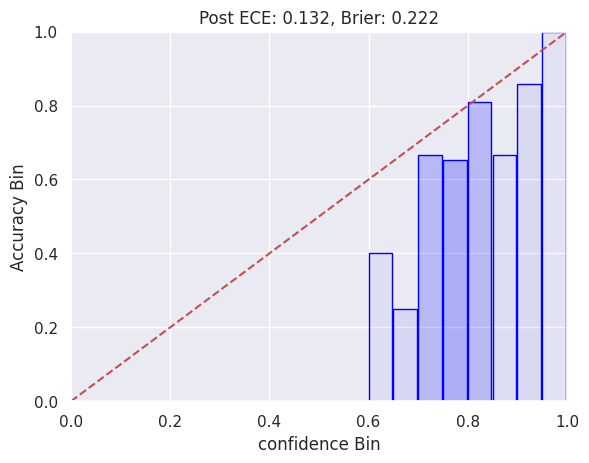

In [57]:
ambigqa_100_res, ambigqa_100_records = read_data(dataset="ambigqa", fpath="ambigqa.jsonl")
ambigqa_100_acc_all, ambigqa_100_conf_all, ambigqa_100_acc_all_zs, ambigqa_100_conf_all_zs, = get_acc_and_conf(gsm8k_100_res, gsm8k_100_records, zs_baseline=True)

ece, prop_all_bins, accuracy_all_bins, bin_boundaries = interval_ece(ambigqa_100_acc_all, ambigqa_100_conf_all)
bs = brier_score(ambigqa_100_acc_all, ambigqa_100_conf_all)
plot_reliability_diagram(bin_boundaries, prop_all_bins, accuracy_all_bins, f"Post ECE: {ece:.3f}, Brier: {bs:.3f}")

in total 100 examples


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


number of unique stances pre stage 2: 1.430, post stage 2: 1.140
majority vote mean confidence pre stage 2: 0.797, post stage 2: 0.906
non-majority mean confidence pre stage 2: 0.747, post stage 2: 0.902
early consensus rate: 0.640; early consensus being correct 95.31% of the time, with avg confidence boost: 16.13%
majority change rate: 0.100; effective rate (changing from incorrect to correct): 60.00% of the time.
compare between pre and post stance distributions - Wasserstein: 1.146 KL: 0.647


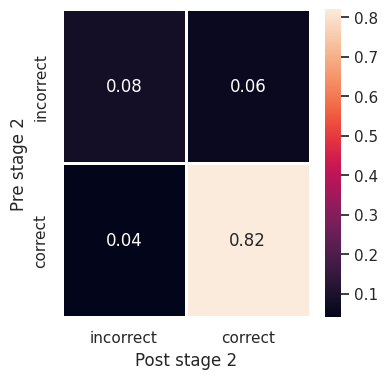

<Figure size 640x480 with 0 Axes>

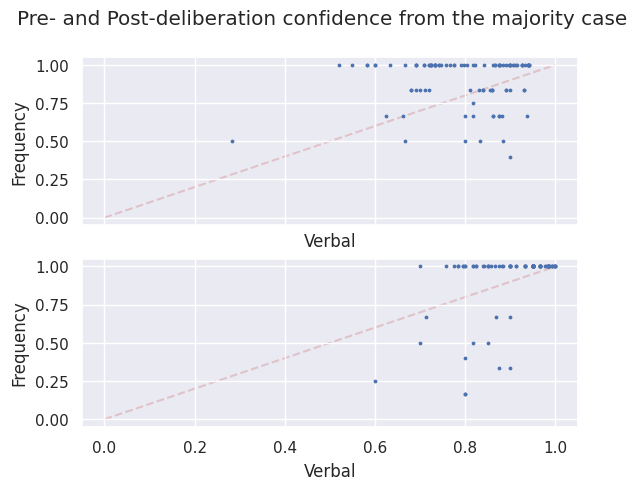

<Figure size 640x480 with 0 Axes>

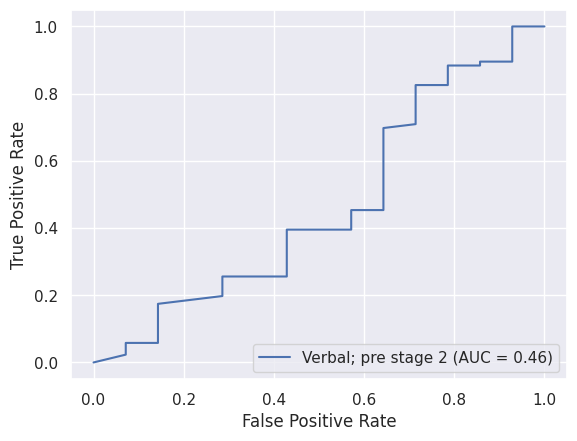

<Figure size 640x480 with 0 Axes>

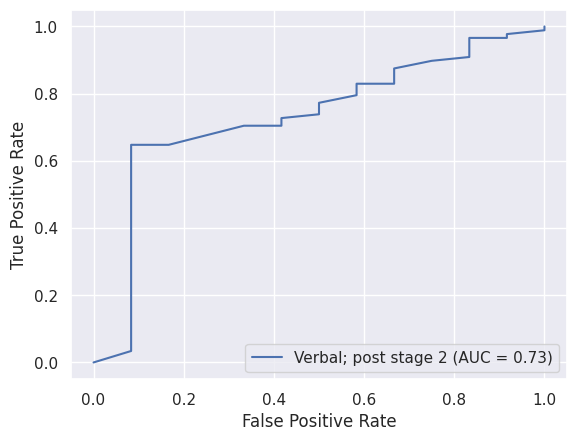

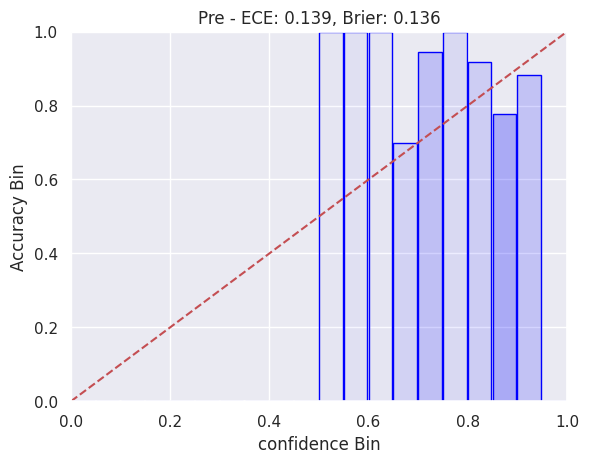

In [58]:
deliberation_ablation(dataset="sciq-valid", fpath="sciq-valid.jsonl")

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]

test run mean accuracy 0.860, mean confidence 0.905
0-shot mean accuracy 0.890, mean confidence 0.895


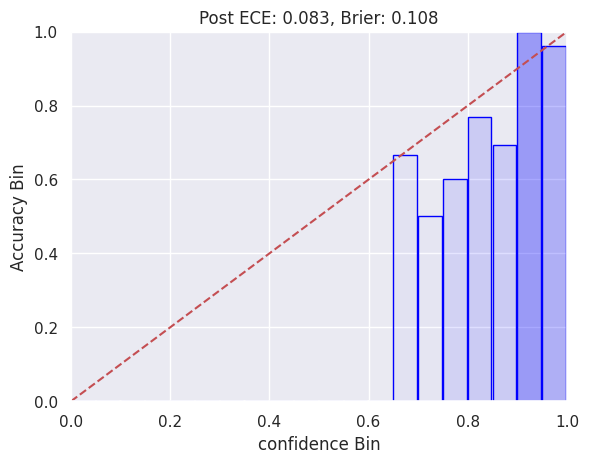

In [59]:
sciq_100_res, sciq_100_records = read_data(dataset="sciq-valid", fpath="sciq-valid.jsonl")
sciq_100_acc_all, sciq_100_conf_all, sciq_100_acc_all_zs, sciq_100_conf_all_zs, = get_acc_and_conf(sciq_100_res, sciq_100_records, zs_baseline=True)

ece, prop_all_bins, accuracy_all_bins, bin_boundaries = interval_ece(sciq_100_acc_all, sciq_100_conf_all)
bs = brier_score(sciq_100_acc_all, sciq_100_conf_all)
plot_reliability_diagram(bin_boundaries, prop_all_bins, accuracy_all_bins, f"Post ECE: {ece:.3f}, Brier: {bs:.3f}")

#### Test runs on GSM8K comparing with ZS

In [32]:
gsm, gsm_records = read_data(dataset="gsm8k-test", fpath="test_runs/gsm8k-test-cot-only.jsonl")
gsm_acc_all, gsm_conf_all, gsm_acc_zs, gsm_conf_zs = get_acc_and_conf(gsm, gsm_records, judge="gpt_cls")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

test run mean accuracy 0.750, mean confidence 0.794
0-shot mean accuracy 0.320, mean confidence 0.920


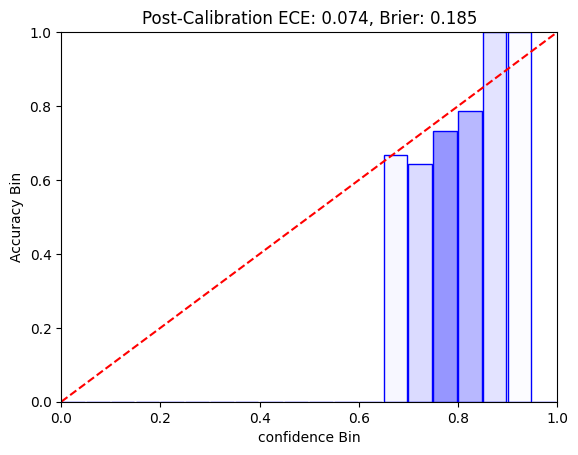

In [33]:
ece, prop_all_bins, accuracy_all_bins, bin_boundaries = interval_ece(gsm_acc_all, gsm_conf_all)
bs = brier_score(gsm_acc_all, gsm_conf_all)
plot_reliability_diagram(bin_boundaries, prop_all_bins, accuracy_all_bins, f"Post-Calibration ECE: {ece:.3f}, Brier: {bs:.3f}")

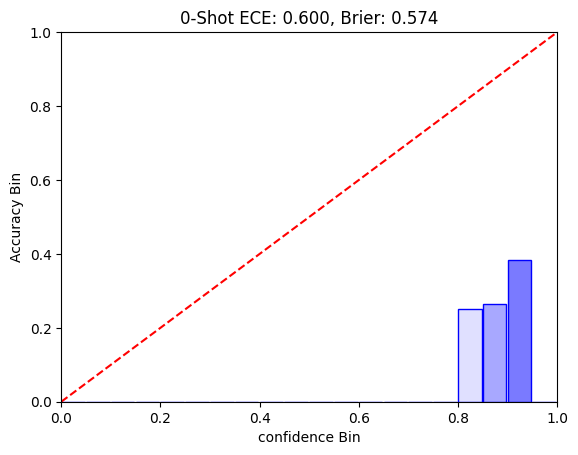

In [34]:
ece, prop_zs_bins, accuracy_zs_bins, bin_boundaries = interval_ece(gsm_acc_zs, gsm_conf_zs)
bs = brier_score(gsm_acc_zs, gsm_conf_zs)
plot_reliability_diagram(bin_boundaries, prop_zs_bins, accuracy_zs_bins, f"0-Shot ECE: {ece:.3f}, Brier: {bs:.3f}")